# データセット定義・統計・妥当性分析

このノートブックでは、査読コメントに対応するため、以下の分析を実行します:

## A. データセット定義・統計・妥当性まわり

1. **データセットの基本情報確認**
2. **ΔpIC50の分布とノイズ評価**
3. **変換ごとのサンプル数の集計**
4. **ポジティブ/ネガティブサンプルの件数・割合**
5. **フラグメントサイズ(15原子)の妥当性検証**
6. **データ分割方法の確認と文書化**

## 1. ライブラリのインポートとデータ読み込み

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 表示設定
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [14]:
# データセットの読み込み
data_path = '/gs/bs/tga-ohuelab/masunaga/MMP_dataset/dataset.csv'
df = pd.read_csv(data_path)

print(f"データセット読み込み完了: {data_path}")
print(f"データ件数: {len(df):,} 件")

データセット読み込み完了: /gs/bs/tga-ohuelab/masunaga/MMP_dataset/dataset.csv
データ件数: 779,081 件


## 2. データセットの基本情報確認

### 2.1 カラム情報とデータ型

In [15]:
# カラム名の表示
print("■ カラム一覧:")
print(df.columns.tolist())
print(f"\n■ カラム数: {len(df.columns)}")
print(f"■ データ件数: {len(df):,} 件")
print(f"\n■ データ型:")
df.info()

■ カラム一覧:
['REF-CID', 'PRB-CID', 'AID', 'TID', 'CUT_NUM', 'COMMON_FRAG', 'REF-FRAG', 'PRB-FRAG', 'SMIRKS', 'REF-FRAG_heavy', 'PRB-FRAG_heavy', 'VAR_heavy_sum', 'REF-standard_value', 'REF-SMILES', 'STANDARD_TYPE', 'PRB-standard_value', 'PRB-SMILES', 'delta_value', 'label_bin']

■ カラム数: 19
■ データ件数: 779,081 件

■ データ型:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779081 entries, 0 to 779080
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   REF-CID             779081 non-null  object 
 1   PRB-CID             779081 non-null  object 
 2   AID                 779081 non-null  int64  
 3   TID                 779081 non-null  object 
 4   CUT_NUM             779081 non-null  int64  
 5   COMMON_FRAG         779081 non-null  object 
 6   REF-FRAG            779081 non-null  object 
 7   PRB-FRAG            779081 non-null  object 
 8   SMIRKS              779081 non-null  object 
 9   REF-FRAG_heavy    

### 2.2 基本統計量

In [16]:
# 数値カラムの基本統計量
print("■ 数値カラムの基本統計量:")
numeric_cols = ['REF-FRAG_heavy', 'PRB-FRAG_heavy', 'VAR_heavy_sum', 
                'REF-standard_value', 'PRB-standard_value', 'delta_value']
df[numeric_cols].describe()

■ 数値カラムの基本統計量:


,REF-FRAG_heavy,PRB-FRAG_heavy,VAR_heavy_sum,REF-standard_value,PRB-standard_value,delta_value
count,779081.000000,779081.000000,779081.000000,779081.000000,779081.000000,779081.000000
mean,9.006934,9.009937,18.016871,1420.766376,1420.536304,-0.008414
std,3.191902,3.201411,5.638517,2969.534576,2964.414589,0.831911
min,1.000000,1.000000,2.000000,0.000008,0.000008,-6.698970
25%,7.000000,7.000000,15.000000,10.000000,10.000000,-0.395415
50%,9.000000,9.000000,18.000000,66.000000,69.070000,0.000000
75%,11.000000,11.000000,22.000000,790.000000,794.330000,0.380211
max,15.000000,15.000000,30.000000,10000.000000,10000.000000,4.989005


In [60]:
# ユニークな値の確認
print("■ ユニークな値の数:")

# REF-SMILESとPRB-SMILESを合わせたユニーク分子数を計算
unique_molecules = pd.concat([df['REF-SMILES'], df['PRB-SMILES']]).nunique()

categorical_info = {
    'AID (Assay ID)': df['AID'].nunique(),
    'TID (Target ID)': df['TID'].nunique(),
    'CUT_NUM (切断番号)': df['CUT_NUM'].nunique(),
    'REF-SMILES': df['REF-SMILES'].nunique(),
    'PRB-SMILES': df['PRB-SMILES'].nunique(),
    'ユニーク分子数 (REF + PRB)': unique_molecules,
    'SMIRKS (変換パターン)': df['SMIRKS'].nunique(),
    'label_bin': df['label_bin'].nunique() if 'label_bin' in df.columns else 'N/A'
}

for key, value in categorical_info.items():
    print(f"  {key}: {value:,}")

■ ユニークな値の数:


  AID (Assay ID): 12,585
  TID (Target ID): 1,897
  CUT_NUM (切断番号): 3
  REF-SMILES: 86,018
  PRB-SMILES: 85,993
  ユニーク分子数 (REF + PRB): 108,607
  SMIRKS (変換パターン): 621,522
  label_bin: 2


## 3. ΔpIC50の分布とノイズ評価

### 3.1 ΔpIC50 (delta_value) の分布

In [18]:
# delta_valueの分布を詳細に確認
print("■ Statistics of ΔpIC50 (delta_value):")
print(df['delta_value'].describe())
print(f"\nMissing values: {df['delta_value'].isna().sum()} samples")
print(f"\nMedian: {df['delta_value'].median():.3f}")
print(f"Standard deviation: {df['delta_value'].std():.3f}")
print(f"Interquartile range (IQR): {df['delta_value'].quantile(0.75) - df['delta_value'].quantile(0.25):.3f}")

# 閾値0.3との関係
print(f"\n■ Relationship with threshold 0.3:")
print(f"|ΔpIC50| < 0.3: {(df['delta_value'].abs() < 0.3).sum():,} samples ({(df['delta_value'].abs() < 0.3).sum() / len(df) * 100:.1f}%)")
print(f"|ΔpIC50| ≥ 0.3: {(df['delta_value'].abs() >= 0.3).sum():,} samples ({(df['delta_value'].abs() >= 0.3).sum() / len(df) * 100:.1f}%)")

■ Statistics of ΔpIC50 (delta_value):
count    779081.000000
mean         -0.008414
std           0.831911
min          -6.698970
25%          -0.395415
50%           0.000000
75%           0.380211
max           4.989005
Name: delta_value, dtype: float64

Missing values: 0 samples

Median: 0.000
Standard deviation: 0.832
Interquartile range (IQR): 0.776

■ Relationship with threshold 0.3:
|ΔpIC50| < 0.3: 330,940 samples (42.5%)
|ΔpIC50| ≥ 0.3: 448,141 samples (57.5%)


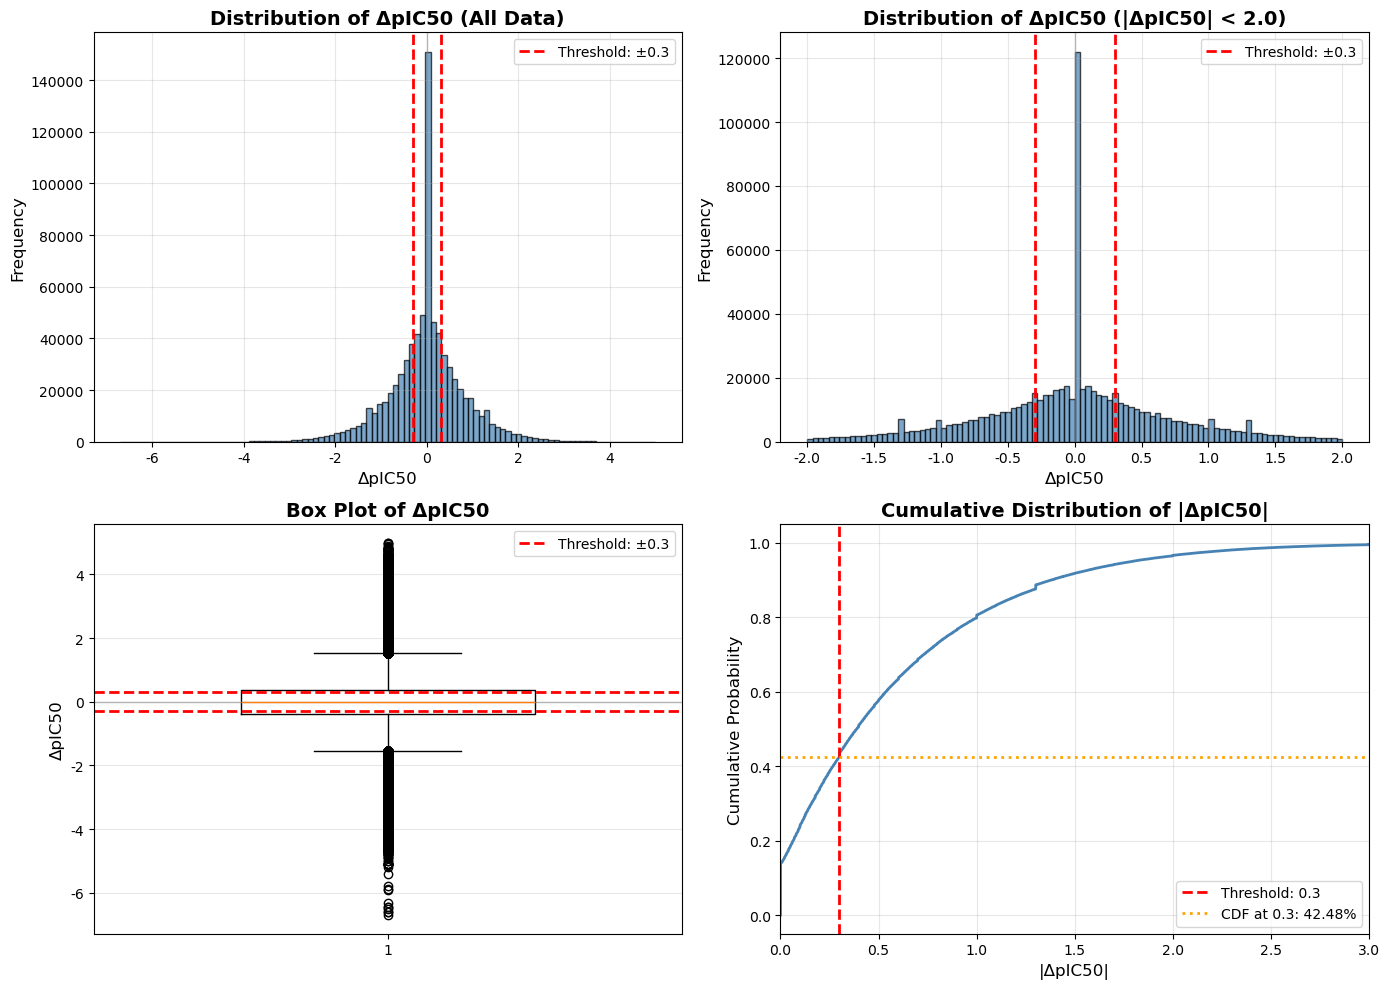

■ Figure 1: Distribution of ΔpIC50 (analyzed from 4 perspectives)


In [19]:
# ΔpIC50の分布を可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ヒストグラム (全体)
axes[0, 0].hist(df['delta_value'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: ±0.3')
axes[0, 0].axvline(x=-0.3, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[0, 0].set_xlabel('ΔpIC50', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of ΔpIC50 (All Data)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. ヒストグラム (|ΔpIC50| < 2.0にズーム)
df_zoom = df[df['delta_value'].abs() < 2.0]
axes[0, 1].hist(df_zoom['delta_value'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: ±0.3')
axes[0, 1].axvline(x=-0.3, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[0, 1].set_xlabel('ΔpIC50', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of ΔpIC50 (|ΔpIC50| < 2.0)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 箱ひげ図
axes[1, 0].boxplot([df['delta_value']], vert=True, widths=0.5)
axes[1, 0].axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: ±0.3')
axes[1, 0].axhline(y=-0.3, color='red', linestyle='--', linewidth=2)
axes[1, 0].axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 0].set_ylabel('ΔpIC50', fontsize=12)
axes[1, 0].set_title('Box Plot of ΔpIC50', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. 累積分布関数 (CDF)
sorted_delta = np.sort(df['delta_value'].abs())
cdf = np.arange(1, len(sorted_delta) + 1) / len(sorted_delta)
axes[1, 1].plot(sorted_delta, cdf, linewidth=2, color='steelblue')
axes[1, 1].axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: 0.3')
axes[1, 1].axhline(y=(df['delta_value'].abs() < 0.3).sum() / len(df), 
                   color='orange', linestyle=':', linewidth=2, 
                   label=f'CDF at 0.3: {(df["delta_value"].abs() < 0.3).sum() / len(df):.2%}')
axes[1, 1].set_xlabel('|ΔpIC50|', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution of |ΔpIC50|', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 3)

plt.tight_layout()
plt.show()

print("■ Figure 1: Distribution of ΔpIC50 (analyzed from 4 perspectives)")

### 3.2 実験ノイズのスケール評価

In [20]:
# 実験ノイズのスケール評価
# |ΔpIC50| < 0.3のデータを「ノイズレベル」と仮定して統計を算出
noise_data = df[df['delta_value'].abs() < 0.3]['delta_value']

print("■ Experimental Noise Scale Evaluation (data with |ΔpIC50| < 0.3):")
print(f"Sample size: {len(noise_data):,} samples")
print(f"Mean: {noise_data.mean():.4f}")
print(f"Median: {noise_data.median():.4f}")
print(f"Standard deviation: {noise_data.std():.4f}")
print(f"95% confidence interval: [{noise_data.quantile(0.025):.4f}, {noise_data.quantile(0.975):.4f}]")

# 閾値0.3と標準偏差の関係
print(f"\n■ Relationship between threshold 0.3 and standard deviation:")
print(f"Overall standard deviation: {df['delta_value'].std():.4f}")
print(f"Noise-level standard deviation: {noise_data.std():.4f}")
print(f"Threshold 0.3 is {0.3 / df['delta_value'].std():.2f}× the overall std")
print(f"Threshold 0.3 is {0.3 / noise_data.std():.2f}× the noise-level std")

■ Experimental Noise Scale Evaluation (data with |ΔpIC50| < 0.3):
Sample size: 330,940 samples
Mean: -0.0003
Median: 0.0000
Standard deviation: 0.1364
95% confidence interval: [-0.2711, 0.2709]

■ Relationship between threshold 0.3 and standard deviation:
Overall standard deviation: 0.8319
Noise-level standard deviation: 0.1364
Threshold 0.3 is 0.36× the overall std
Threshold 0.3 is 2.20× the noise-level std


### 3.3 ΔpIC50 = 0.0 の詳細分析

In [21]:
# ΔpIC50 = 0.0 のサンプルを抽出して分析
df_zero = df[df['delta_value'] == 0.0]

print("■ ΔpIC50 = 0.0 Analysis:")
print(f"Total samples with ΔpIC50 = 0.0: {len(df_zero):,} samples")
print(f"Percentage: {len(df_zero)/len(df)*100:.2f}% of all data")

# REF-SMILESとPRB-SMILESが同一かチェック
identical_smiles = (df_zero['REF-SMILES'] == df_zero['PRB-SMILES']).sum()
print(f"\n■ SMILES comparison:")
print(f"Identical SMILES (REF == PRB): {identical_smiles:,} samples ({identical_smiles/len(df_zero)*100:.2f}%)")
print(f"Different SMILES (REF != PRB): {len(df_zero) - identical_smiles:,} samples ({(len(df_zero) - identical_smiles)/len(df_zero)*100:.2f}%)")

# REF-CIDとPRB-CIDが同一かチェック
identical_cid = (df_zero['REF-CID'] == df_zero['PRB-CID']).sum()
print(f"\n■ Compound ID comparison:")
print(f"Identical CID (REF == PRB): {identical_cid:,} samples ({identical_cid/len(df_zero)*100:.2f}%)")
print(f"Different CID (REF != PRB): {len(df_zero) - identical_cid:,} samples ({(len(df_zero) - identical_cid)/len(df_zero)*100:.2f}%)")

# pIC50値を確認
print(f"\n■ pIC50 values for ΔpIC50 = 0.0:")
print(f"REF-standard_value statistics:")
print(df_zero['REF-standard_value'].describe())
print(f"\nPRB-standard_value statistics:")
print(df_zero['PRB-standard_value'].describe())

# REFとPRBのpIC50値の差を再計算して確認
recalc_delta = df_zero['PRB-standard_value'] - df_zero['REF-standard_value']
print(f"\n■ Recalculated delta (PRB - REF):")
print(f"Min: {recalc_delta.min():.6f}")
print(f"Max: {recalc_delta.max():.6f}")
print(f"Mean: {recalc_delta.mean():.6f}")
print(f"Std: {recalc_delta.std():.6f}")

# 完全に同一の値の割合
truly_identical = (df_zero['REF-standard_value'] == df_zero['PRB-standard_value']).sum()
print(f"\nTruly identical pIC50 values: {truly_identical:,} samples ({truly_identical/len(df_zero)*100:.2f}%)")

■ ΔpIC50 = 0.0 Analysis:
Total samples with ΔpIC50 = 0.0: 108,272 samples
Percentage: 13.90% of all data

■ SMILES comparison:
Identical SMILES (REF == PRB): 2 samples (0.00%)
Different SMILES (REF != PRB): 108,270 samples (100.00%)

■ Compound ID comparison:
Identical CID (REF == PRB): 0 samples (0.00%)
Different CID (REF != PRB): 108,272 samples (100.00%)

■ pIC50 values for ΔpIC50 = 0.0:
REF-standard_value statistics:
count    108272.000000
mean       4380.215838
std        4787.480343
min           0.000050
25%          50.000000
50%        1000.000000
75%       10000.000000
max       10000.000000
Name: REF-standard_value, dtype: float64

PRB-standard_value statistics:
count    108272.000000
mean       4380.215838
std        4787.480343
min           0.000050
25%          50.000000
50%        1000.000000
75%       10000.000000
max       10000.000000
Name: PRB-standard_value, dtype: float64

■ Recalculated delta (PRB - REF):
Min: 0.000000
Max: 0.000000
Mean: 0.000000
Std: 0.000000



In [22]:
# ΔpIC50 = 0.0 のフラグメント分析
print("■ Fragment analysis for ΔpIC50 = 0.0:")

# REF-FRAGとPRB-FRAGが同一かチェック
identical_frag = (df_zero['REF-FRAG'] == df_zero['PRB-FRAG']).sum()
print(f"Identical fragments (REF-FRAG == PRB-FRAG): {identical_frag:,} samples ({identical_frag/len(df_zero)*100:.2f}%)")
print(f"Different fragments: {len(df_zero) - identical_frag:,} samples ({(len(df_zero) - identical_frag)/len(df_zero)*100:.2f}%)")

# SMIRKS分析
print(f"\n■ SMIRKS patterns for ΔpIC50 = 0.0:")
smirks_zero_counts = df_zero['SMIRKS'].value_counts()
print(f"Unique SMIRKS patterns: {len(smirks_zero_counts):,} types")
print(f"\nTop 10 SMIRKS patterns:")
for i, (smirks, count) in enumerate(smirks_zero_counts.head(10).items(), 1):
    print(f"  {i}. Count: {count:4,} - {smirks[:80]}{'...' if len(smirks) > 80 else ''}")

# ターゲット分析
print(f"\n■ Target distribution for ΔpIC50 = 0.0:")
target_zero_counts = df_zero['TID'].value_counts()
print(f"Unique targets (TID): {len(target_zero_counts):,}")
print(f"Top 5 targets:")
for i, (tid, count) in enumerate(target_zero_counts.head(5).items(), 1):
    print(f"  {i}. TID {tid}: {count:,} samples ({count/len(df_zero)*100:.1f}%)")

■ Fragment analysis for ΔpIC50 = 0.0:
Identical fragments (REF-FRAG == PRB-FRAG): 0 samples (0.00%)
Different fragments: 108,272 samples (100.00%)

■ SMIRKS patterns for ΔpIC50 = 0.0:
Unique SMIRKS patterns: 87,201 types

Top 10 SMIRKS patterns:
  1. Count:   12 - [[15*]COc1cccc(-c2cn([C@H]3C[C@@H](CN4CCC4)C3)c3ncnc(N)c23)c1]>>[[14*][C@@H]1CCC...
  2. Count:   11 - [[14*]Oc1cccc(-c2cn([C@H]3C[C@@H](CN4CCC4)C3)c3ncnc(N)c23)c1]>>[[13*]C[C@@H]1CCC...
  3. Count:   10 - [[14*]Oc1cccc(-c2cn([C@H]3C[C@@H](CN4CCC4)C3)c3ncnc(N)c23)c1]>>[[13*]Cc1ccccc1]|...
  4. Count:    9 - [[12*]CCCOc1cccc(CC(=O)Nc2nc(-c3ccncc3)cs2)c1]>>[[11*]C1CCNCC1]|[[11*]N1CCNCC1]
  5. Count:    8 - [[24*]C(N)=O.[24*]N(C)Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2cc1OC]>>[[22*][C@@H]([26*])C]|...
  6. Count:    8 - [[22*]Cc1cc2c(Nc3cccc(Cl)c3F)ncnc2cc1OC]>>[[21*]N[C@H](C)C(N)=O]|[[21*]N(C)[C@@H...
  7. Count:    8 - [[12*]CCCOc1cccc(CC(=O)Nc2nc(-c3ccncc3)cs2)c1]>>[[11*]N1CCNCC1]|[[11*]C1CCNCC1]
  8. Count:    8 - [[14*]Oc1cccc(-c2cn([C

■ Structure visualization for ΔpIC50 = 0.0 samples (first 10 pairs)

★ Different SMILES but ΔpIC50 = 0.0 (first 5 pairs):

--- Pair 1 ---
REF-CID: CHEMBL311378, PRB-CID: CHEMBL81623
REF pIC50: 1000.0000, PRB pIC50: 1000.0000, Δ: 0.000000
REF-SMILES: CCCN1CCC(c2cccnc2)C1
PRB-SMILES: CCCN1CCC(C2CCCCC2)C1
Identical: False


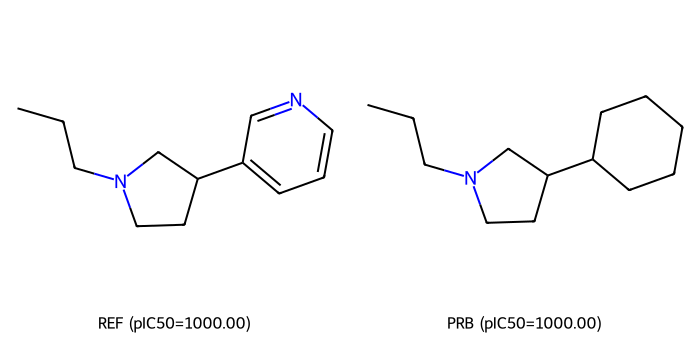

--------------------------------------------------------------------------------

--- Pair 2 ---
REF-CID: CHEMBL91534, PRB-CID: CHEMBL304857
REF pIC50: 2.2000, PRB pIC50: 2.2000, Δ: 0.000000
REF-SMILES: CN(Cc1ccccc1)[C@H]1CCN(CCCc2c[nH]c3ccc(-n4cnnc4)cc23)C[C@H]1F
PRB-SMILES: CN(Cc1ccccc1)C1CCN(CCCc2c[nH]c3ccc(-n4cnnc4)cc23)CC1
Identical: False


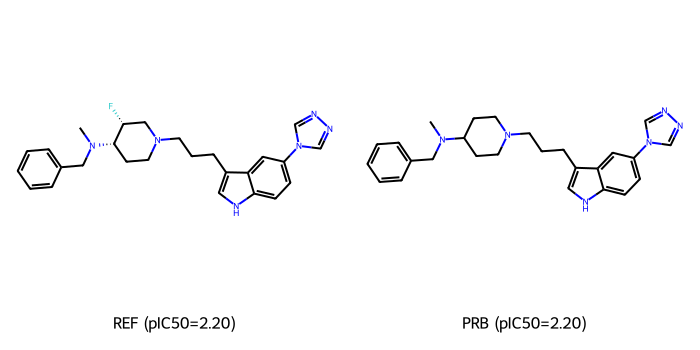

--------------------------------------------------------------------------------

--- Pair 3 ---
REF-CID: CHEMBL418790, PRB-CID: CHEMBL95685
REF pIC50: 1000.0000, PRB pIC50: 1000.0000, Δ: 0.000000
REF-SMILES: CC(C)n1c(=O)n(C(=O)NCCN2CCN(C)CC2)c2cc(Cl)ccc21
PRB-SMILES: CC(C)n1c(=O)n(C(=O)NCCN2CCN(C)CC2)c2cc(F)c(N)cc21
Identical: False


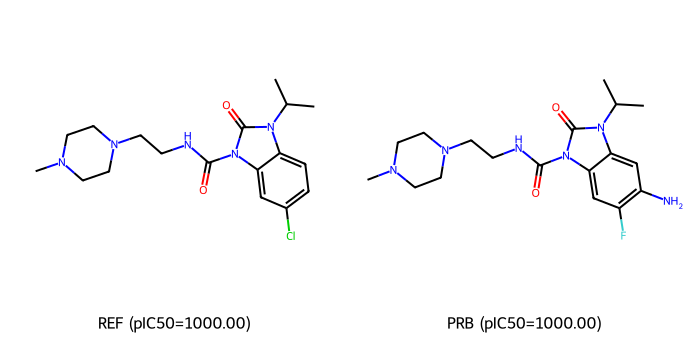

--------------------------------------------------------------------------------

--- Pair 4 ---
REF-CID: CHEMBL317377, PRB-CID: CHEMBL318068
REF pIC50: 1000.0000, PRB pIC50: 1000.0000, Δ: 0.000000
REF-SMILES: CC(C)n1c(=O)n(C(=O)NN2CCN(C)CC2)c2ccccc21
PRB-SMILES: CC(C)n1c(=O)n(C(=O)NCCCN2CCN(C)CC2)c2ccccc21
Identical: False


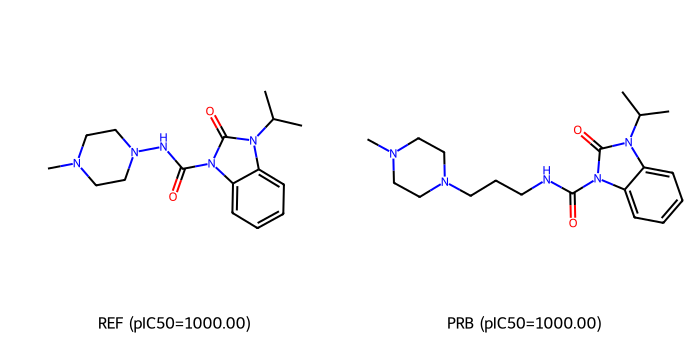

--------------------------------------------------------------------------------

--- Pair 5 ---
REF-CID: CHEMBL317377, PRB-CID: CHEMBL96960
REF pIC50: 1000.0000, PRB pIC50: 1000.0000, Δ: 0.000000
REF-SMILES: CC(C)n1c(=O)n(C(=O)NN2CCN(C)CC2)c2ccccc21
PRB-SMILES: CC(C)n1c(=O)n(C(=O)NCN2CCN(C)CC2)c2ccccc21
Identical: False


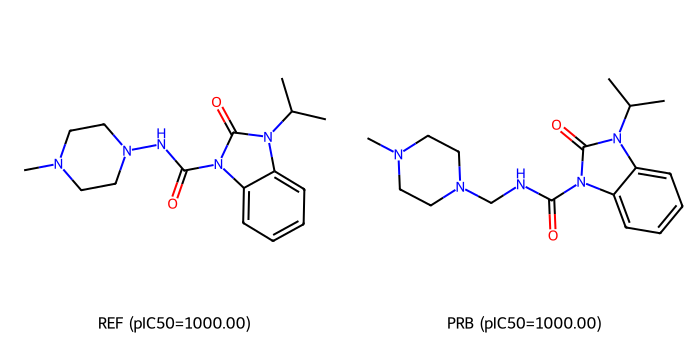

--------------------------------------------------------------------------------


In [23]:
# ΔpIC50 = 0.0 の構造を可視化（サンプル）
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

print("■ Structure visualization for ΔpIC50 = 0.0 samples (first 10 pairs)")
print("="*80)

# 異なるSMILESを持つΔ=0.0のサンプルを優先的に表示
df_zero_diff = df_zero[df_zero['REF-SMILES'] != df_zero['PRB-SMILES']]

if len(df_zero_diff) > 0:
    print(f"\n★ Different SMILES but ΔpIC50 = 0.0 (first 5 pairs):")
    sample_df = df_zero_diff.head(5)
else:
    print(f"\n★ Random samples with ΔpIC50 = 0.0 (first 5 pairs):")
    sample_df = df_zero.head(5)

for idx, (index, row) in enumerate(sample_df.iterrows(), 1):
    ref_smiles = row['REF-SMILES']
    prb_smiles = row['PRB-SMILES']
    ref_value = row['REF-standard_value']
    prb_value = row['PRB-standard_value']
    ref_cid = row['REF-CID']
    prb_cid = row['PRB-CID']
    
    print(f"\n--- Pair {idx} ---")
    print(f"REF-CID: {ref_cid}, PRB-CID: {prb_cid}")
    print(f"REF pIC50: {ref_value:.4f}, PRB pIC50: {prb_value:.4f}, Δ: {prb_value - ref_value:.6f}")
    print(f"REF-SMILES: {ref_smiles[:80]}{'...' if len(ref_smiles) > 80 else ''}")
    print(f"PRB-SMILES: {prb_smiles[:80]}{'...' if len(prb_smiles) > 80 else ''}")
    print(f"Identical: {ref_smiles == prb_smiles}")
    
    # 構造を可視化
    mols = []
    legends = []
    
    try:
        mol_ref = Chem.MolFromSmiles(ref_smiles)
        if mol_ref:
            mols.append(mol_ref)
            legends.append(f"REF (pIC50={ref_value:.2f})")
    except:
        pass
    
    try:
        mol_prb = Chem.MolFromSmiles(prb_smiles)
        if mol_prb:
            mols.append(mol_prb)
            legends.append(f"PRB (pIC50={prb_value:.2f})")
    except:
        pass
    
    if len(mols) >= 1:
        if len(mols) == 2 and ref_smiles != prb_smiles:
            img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(350, 350), legends=legends)
        else:
            img = Draw.MolsToGridImage([mols[0]], molsPerRow=1, subImgSize=(350, 350), legends=[legends[0]])
        display(img)
    
    print("-"*80)

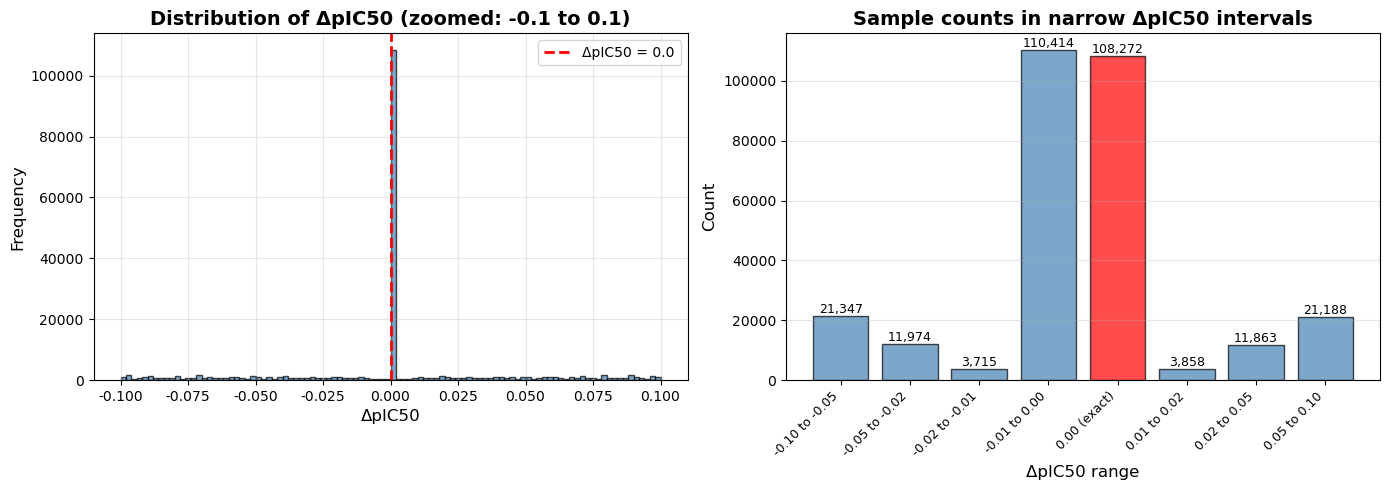


■ Analysis of near-zero ΔpIC50:
Exact 0.0: 108,272 samples (13.90%)
-0.01 < Δ < 0.01 (excluding 0.0): 4,322 samples
-0.02 < Δ < 0.02 (excluding 0.0): 11,895 samples


In [24]:
# ΔpIC50の分布をより詳細に確認（0.0付近を拡大）
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. ΔpIC50のヒストグラム（-0.1 ~ 0.1の範囲）
df_near_zero = df[(df['delta_value'] >= -0.1) & (df['delta_value'] <= 0.1)]
axes[0].hist(df_near_zero['delta_value'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='ΔpIC50 = 0.0')
axes[0].set_xlabel('ΔpIC50', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of ΔpIC50 (zoomed: -0.1 to 0.1)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. ΔpIC50 = 0.0 の割合を他の小区間と比較
bins = [-0.1, -0.05, -0.02, -0.01, 0.0, 0.01, 0.02, 0.05, 0.1]
bin_labels = [f'{bins[i]:.2f} to {bins[i+1]:.2f}' for i in range(len(bins)-1)]
bin_labels[4] = '0.00 (exact)'  # ΔpIC50 = 0.0 を強調

# 各区間のカウント
counts = []
for i in range(len(bins)-1):
    if i == 4:  # ΔpIC50 = 0.0
        count = (df['delta_value'] == 0.0).sum()
    else:
        count = ((df['delta_value'] > bins[i]) & (df['delta_value'] <= bins[i+1])).sum()
    counts.append(count)

axes[1].bar(range(len(counts)), counts, alpha=0.7, edgecolor='black', 
            color=['steelblue' if i != 4 else 'red' for i in range(len(counts))])
axes[1].set_xlabel('ΔpIC50 range', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Sample counts in narrow ΔpIC50 intervals', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(counts)))
axes[1].set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

# 各バーの上に数値を表示
for i, count in enumerate(counts):
    axes[1].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n■ Analysis of near-zero ΔpIC50:")
print(f"Exact 0.0: {(df['delta_value'] == 0.0).sum():,} samples ({(df['delta_value'] == 0.0).sum()/len(df)*100:.2f}%)")
print(f"-0.01 < Δ < 0.01 (excluding 0.0): {((df['delta_value'].abs() < 0.01) & (df['delta_value'] != 0.0)).sum():,} samples")
print(f"-0.02 < Δ < 0.02 (excluding 0.0): {((df['delta_value'].abs() < 0.02) & (df['delta_value'] != 0.0)).sum():,} samples")

## 4. 変換ごとのサンプル数の集計



### 4.1 フラグメントペア (順不同) ごとのサンプル数

In [25]:
# フラグメント番号を正規化する関数 (exp.ipynbと同様)
import re

def remove_attachment_numbers(frag):
    """
    フラグメント文字列から結合位置の数字を削除する
    例: [10*]C -> [*]C, [11*]C -> [*]C
    """
    if pd.isna(frag):
        return frag
    # [数字*] を [*] に置き換え
    normalized = re.sub(r'\[(\d+)\*\]', '[*]', frag)
    return normalized

# フラグメントを正規化
print("■ Normalizing fragments...")
df['REF-FRAG-NORM'] = df['REF-FRAG'].apply(remove_attachment_numbers)
df['PRB-FRAG-NORM'] = df['PRB-FRAG'].apply(remove_attachment_numbers)
print("Completed.")

# 順不同(順序を無視)でREF-FRAGとPRB-FRAGの組をカウント
# 各行でREF-FRAGとPRB-FRAGをソートして、常に小さい方を先にする
df['FRAG_PAIR'] = df.apply(
    lambda row: tuple(sorted([row['REF-FRAG-NORM'], row['PRB-FRAG-NORM']])), 
    axis=1
)

# ソート済みのペアでグループ化
grouped_counts_unordered = df.groupby('FRAG_PAIR').size().reset_index(name='count')
grouped_counts_unordered = grouped_counts_unordered.sort_values('count', ascending=False)

print("\n■ Sample count statistics for fragment pairs (unordered):")
print(f"Total unique fragment pairs: {len(grouped_counts_unordered):,} types")
print(f"\nSample count statistics:")
print(grouped_counts_unordered['count'].describe())

# サンプル数の分布
print(f"\n■ Distribution of sample counts:")
thresholds = [1, 2, 3, 5, 10, 20, 50, 100]
for threshold in thresholds:
    count = (grouped_counts_unordered['count'] >= threshold).sum()
    print(f"n ≥ {threshold:3d}: {count:5,} types ({count/len(grouped_counts_unordered)*100:5.1f}%)")

■ Normalizing fragments...


Completed.

■ Sample count statistics for fragment pairs (unordered):
Total unique fragment pairs: 380,847 types

Sample count statistics:
count    380847.000000
mean          2.045654
std           5.482583
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1175.000000
Name: count, dtype: float64

■ Distribution of sample counts:
n ≥   1: 380,847 types (100.0%)
n ≥   2: 150,316 types ( 39.5%)
n ≥   3: 89,893 types ( 23.6%)
n ≥   5: 16,029 types (  4.2%)
n ≥  10: 4,296 types (  1.1%)
n ≥  20: 1,471 types (  0.4%)
n ≥  50:   358 types (  0.1%)
n ≥ 100:   133 types (  0.0%)

■ Sample count statistics for fragment pairs (unordered):
Total unique fragment pairs: 380,847 types

Sample count statistics:
count    380847.000000
mean          2.045654
std           5.482583
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1175.000000
Name: count, dtype: float64

■ Distribution of sample cou

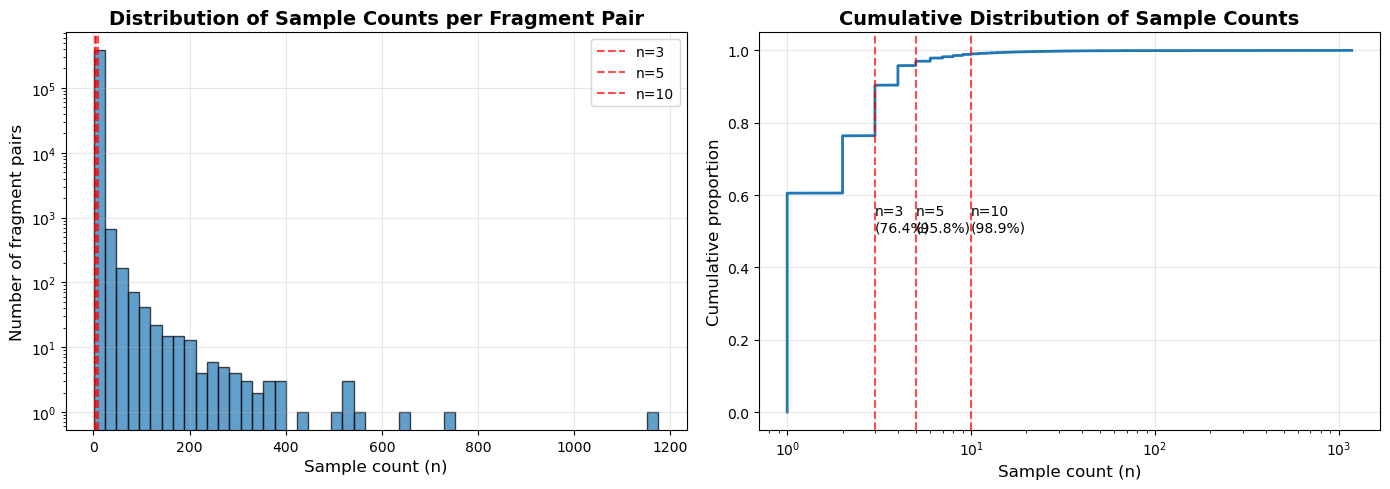


■ Number of fragment pairs at each threshold:
n ≥  3: 89,893 types ( 23.6%)
n <   3: 290,954 types ( 76.4%)

n ≥  5: 16,029 types (  4.2%)
n <   5: 364,818 types ( 95.8%)

n ≥ 10: 4,296 types (  1.1%)
n <  10: 376,551 types ( 98.9%)

n ≥ 20: 1,471 types (  0.4%)
n <  20: 379,376 types ( 99.6%)



In [26]:
# サンプル数の分布を可視化
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: ヒストグラム (対数スケール)
axes[0].hist(grouped_counts_unordered['count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sample count (n)', fontsize=12)
axes[0].set_ylabel('Number of fragment pairs', fontsize=12)
axes[0].set_title('Distribution of Sample Counts per Fragment Pair', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# 垂直線: 閾値
for threshold in [3, 5, 10]:
    axes[0].axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'n={threshold}')
axes[0].legend()

# 右: 累積分布 (CDF)
sorted_counts = np.sort(grouped_counts_unordered['count'].values)
cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

axes[1].plot(sorted_counts, cdf, linewidth=2)
axes[1].set_xlabel('Sample count (n)', fontsize=12)
axes[1].set_ylabel('Cumulative proportion', fontsize=12)
axes[1].set_title('Cumulative Distribution of Sample Counts', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

# 閾値の位置を示す
for threshold in [3, 5, 10]:
    cdf_val = (sorted_counts < threshold).sum() / len(sorted_counts)
    axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[1].text(threshold, 0.5, f'n={threshold}\n({cdf_val*100:.1f}%)', 
                 rotation=0, ha='left', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n■ Number of fragment pairs at each threshold:")
for threshold in [3, 5, 10, 20]:
    count_above = (grouped_counts_unordered['count'] >= threshold).sum()
    count_below = (grouped_counts_unordered['count'] < threshold).sum()
    print(f"n ≥ {threshold:2d}: {count_above:5,} types ({count_above/len(grouped_counts_unordered)*100:5.1f}%)")
    print(f"n <  {threshold:2d}: {count_below:5,} types ({count_below/len(grouped_counts_unordered)*100:5.1f}%)")
    print()

### 4.2 高頻度フラグメントペアの可視化 (Top 10)

■ Structure visualization of Top 10 most frequent fragment pairs

Pair 1: Occurrence = 1,175 samples
  Positive (label=True):    562 samples ( 47.8%)
  Negative (label=False):   613 samples ( 52.2%)
REF-FRAG: [*][C@@H]([*])[*]
PRB-FRAG: [*][C@H]([*])[*]


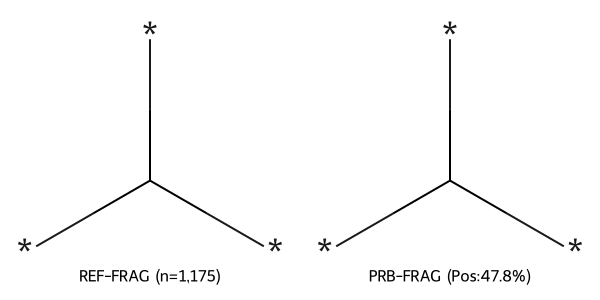

--------------------------------------------------------------------------------

Pair 2: Occurrence = 752 samples
  Positive (label=True):    418 samples ( 55.6%)
  Negative (label=False):   334 samples ( 44.4%)
REF-FRAG: *C([*])C
PRB-FRAG: *C[*]


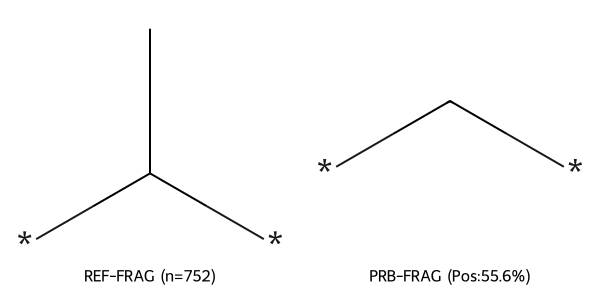

--------------------------------------------------------------------------------

Pair 3: Occurrence = 645 samples
  Positive (label=True):    430 samples ( 66.7%)
  Negative (label=False):   215 samples ( 33.3%)
REF-FRAG: [*]N1CCCC1
PRB-FRAG: [*]N1CCCCC1


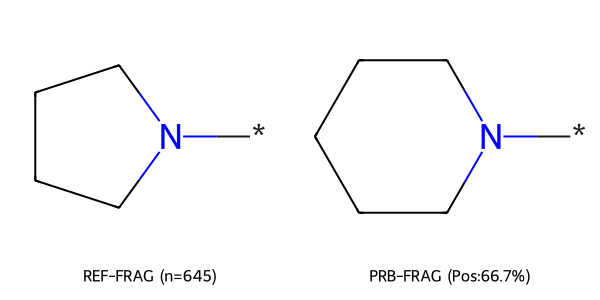

--------------------------------------------------------------------------------

Pair 4: Occurrence = 545 samples
  Positive (label=True):    290 samples ( 53.2%)
  Negative (label=False):   255 samples ( 46.8%)
REF-FRAG: [*]N1CCCC1
PRB-FRAG: [*]N1CCOCC1

Pair 4: Occurrence = 545 samples
  Positive (label=True):    290 samples ( 53.2%)
  Negative (label=False):   255 samples ( 46.8%)
REF-FRAG: [*]N1CCCC1
PRB-FRAG: [*]N1CCOCC1


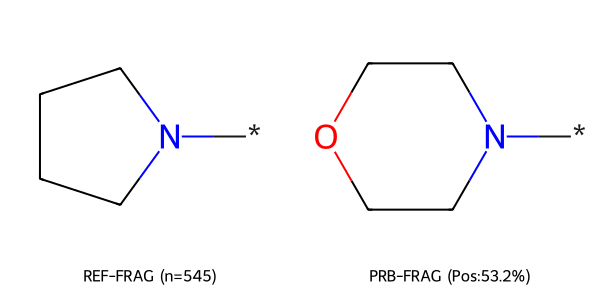

--------------------------------------------------------------------------------

Pair 5: Occurrence = 541 samples
  Positive (label=True):    279 samples ( 51.6%)
  Negative (label=False):   262 samples ( 48.4%)
REF-FRAG: [*]N1CCCCC1
PRB-FRAG: [*]N1CCOCC1

Pair 5: Occurrence = 541 samples
  Positive (label=True):    279 samples ( 51.6%)
  Negative (label=False):   262 samples ( 48.4%)
REF-FRAG: [*]N1CCCCC1
PRB-FRAG: [*]N1CCOCC1


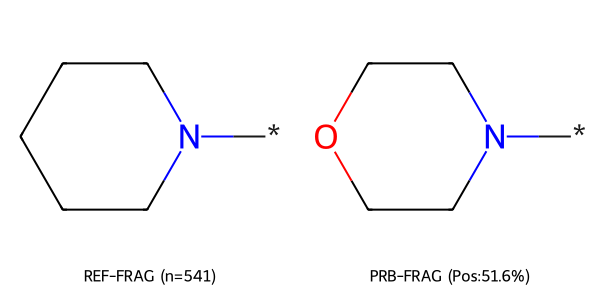

--------------------------------------------------------------------------------

Pair 6: Occurrence = 533 samples
  Positive (label=True):    259 samples ( 48.6%)
  Negative (label=False):   274 samples ( 51.4%)
REF-FRAG: [*]CCc1ccccc1
PRB-FRAG: [*]Cc1ccccc1

Pair 6: Occurrence = 533 samples
  Positive (label=True):    259 samples ( 48.6%)
  Negative (label=False):   274 samples ( 51.4%)
REF-FRAG: [*]CCc1ccccc1
PRB-FRAG: [*]Cc1ccccc1


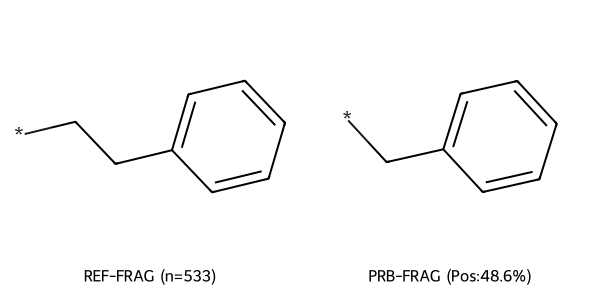

--------------------------------------------------------------------------------

Pair 7: Occurrence = 518 samples
  Positive (label=True):    226 samples ( 43.6%)
  Negative (label=False):   292 samples ( 56.4%)
REF-FRAG: [*]N([*])C
PRB-FRAG: [*]N[*]

Pair 7: Occurrence = 518 samples
  Positive (label=True):    226 samples ( 43.6%)
  Negative (label=False):   292 samples ( 56.4%)
REF-FRAG: [*]N([*])C
PRB-FRAG: [*]N[*]


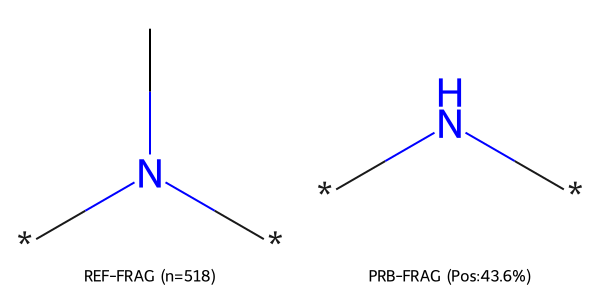

--------------------------------------------------------------------------------

Pair 8: Occurrence = 507 samples
  Positive (label=True):    309 samples ( 60.9%)
  Negative (label=False):   198 samples ( 39.1%)
REF-FRAG: [*]C
PRB-FRAG: [*]CC

Pair 8: Occurrence = 507 samples
  Positive (label=True):    309 samples ( 60.9%)
  Negative (label=False):   198 samples ( 39.1%)
REF-FRAG: [*]C
PRB-FRAG: [*]CC


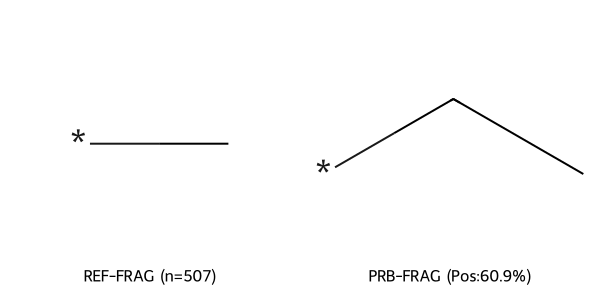

--------------------------------------------------------------------------------

Pair 9: Occurrence = 437 samples
  Positive (label=True):    191 samples ( 43.7%)
  Negative (label=False):   246 samples ( 56.3%)
REF-FRAG: [*]N
PRB-FRAG: [*]O

Pair 9: Occurrence = 437 samples
  Positive (label=True):    191 samples ( 43.7%)
  Negative (label=False):   246 samples ( 56.3%)
REF-FRAG: [*]N
PRB-FRAG: [*]O


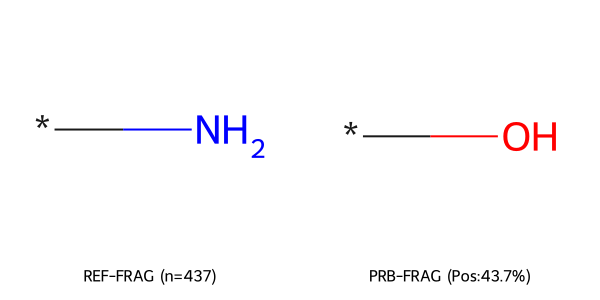

--------------------------------------------------------------------------------

Pair 10: Occurrence = 399 samples
  Positive (label=True):    145 samples ( 36.3%)
  Negative (label=False):   254 samples ( 63.7%)
REF-FRAG: *N([*])C
PRB-FRAG: *N[*]

Pair 10: Occurrence = 399 samples
  Positive (label=True):    145 samples ( 36.3%)
  Negative (label=False):   254 samples ( 63.7%)
REF-FRAG: *N([*])C
PRB-FRAG: *N[*]


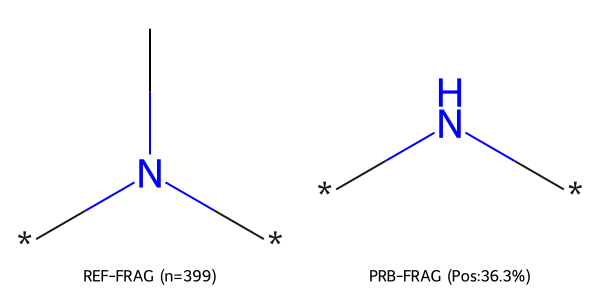

--------------------------------------------------------------------------------


In [27]:
# 最も出現頻度の高いフラグメントペアTop 10を可視化
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Top 10のフラグメントペアを抽出
top_pairs = grouped_counts_unordered.head(10).copy()

# FRAG_PAIRのタプルをREF-FRAG-NORMとPRB-FRAG-NORMに分解
top_pairs[['REF-FRAG-NORM', 'PRB-FRAG-NORM']] = pd.DataFrame(
    top_pairs['FRAG_PAIR'].tolist(), 
    index=top_pairs.index
)

print("■ Structure visualization of Top 10 most frequent fragment pairs")
print("=" * 80)

for idx, (index, row) in enumerate(top_pairs.iterrows(), 1):
    ref_frag = row['REF-FRAG-NORM']
    prb_frag = row['PRB-FRAG-NORM']
    count = row['count']
    frag_pair = row['FRAG_PAIR']
    
    # このフラグメントペアに対応するデータを抽出
    pair_data = df[df['FRAG_PAIR'] == frag_pair]
    
    # label_binの統計を計算
    n_positive = (pair_data['label_bin'] == True).sum()
    n_negative = (pair_data['label_bin'] == False).sum()
    pos_ratio = n_positive / count * 100 if count > 0 else 0
    neg_ratio = n_negative / count * 100 if count > 0 else 0
    
    print(f"\nPair {idx}: Occurrence = {count:,} samples")
    print(f"  Positive (label=True):  {n_positive:5,} samples ({pos_ratio:5.1f}%)")
    print(f"  Negative (label=False): {n_negative:5,} samples ({neg_ratio:5.1f}%)")
    print(f"REF-FRAG: {ref_frag}")
    print(f"PRB-FRAG: {prb_frag}")
    
    # 両方のフラグメントを横に並べて表示
    mols = []
    legends = []
    
    # REF-FRAGを分子として解釈
    try:
        mol_ref = Chem.MolFromSmiles(ref_frag)
        if mol_ref:
            mols.append(mol_ref)
            legends.append(f"REF-FRAG (n={count:,})")
        else:
            print("⚠ Failed to parse REF-FRAG structure")
    except Exception as e:
        print(f"⚠ REF-FRAG error: {e}")
    
    # PRB-FRAGを分子として解釈
    try:
        mol_prb = Chem.MolFromSmiles(prb_frag)
        if mol_prb:
            mols.append(mol_prb)
            legends.append(f"PRB-FRAG (Pos:{pos_ratio:.1f}%)")
        else:
            print("⚠ Failed to parse PRB-FRAG structure")
    except Exception as e:
        print(f"⚠ PRB-FRAG error: {e}")
    
    # 2つの構造を横に並べて表示
    if len(mols) == 2:
        img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300), 
                                     legends=legends)
        display(img)
    elif len(mols) == 1:
        display(Draw.MolToImage(mols[0], size=(300, 300)))
    
    print("-" * 80)

### 4.3 分子ペア (順不同) ごとのサンプル数

In [65]:
# 分子ペア（REF-SMILESとPRB-SMILES）を順不同でカウント
# 各行でREF-SMILESとPRB-SMILESをソートして、常に小さい方を先にする
df['MOLECULE_PAIR'] = df.apply(
    lambda row: tuple(sorted([row['REF-SMILES'], row['PRB-SMILES']])), 
    axis=1
)

# ソート済みのペアでグループ化
grouped_molecule_counts = df.groupby('MOLECULE_PAIR').size().reset_index(name='count')
grouped_molecule_counts = grouped_molecule_counts.sort_values('count', ascending=False)

print("■ Sample count statistics for molecule pairs (unordered):")
print(f"Total unique molecule pairs: {len(grouped_molecule_counts):,} types")
print(f"\nSample count statistics:")
print(grouped_molecule_counts['count'].describe())

# サンプル数の分布
print(f"\n■ Distribution of sample counts:")
thresholds = [1, 2, 3, 5, 10, 20, 50, 100]
for threshold in thresholds:
    count = (grouped_molecule_counts['count'] >= threshold).sum()
    print(f"n ≥ {threshold:3d}: {count:5,} types ({count/len(grouped_molecule_counts)*100:5.1f}%)")

KeyboardInterrupt: 

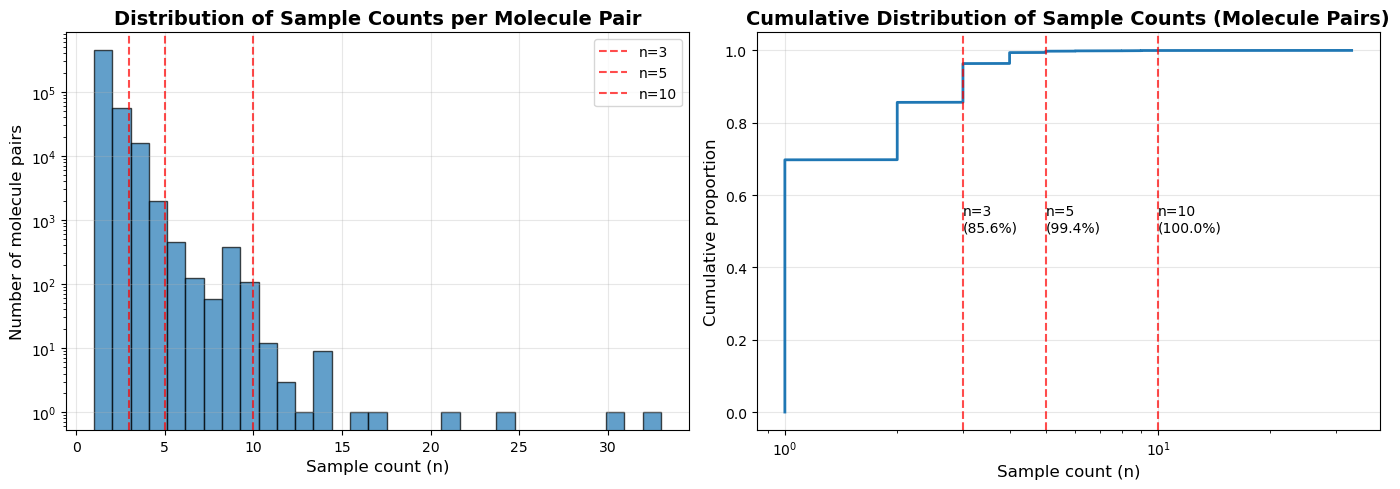


■ Number of molecule pairs at each threshold:
n ≥  3: 74,888 types ( 14.4%)
n <   3: 446,334 types ( 85.6%)

n ≥  5: 3,138 types (  0.6%)
n <   5: 518,084 types ( 99.4%)

n ≥ 10:   138 types (  0.0%)
n <  10: 521,084 types (100.0%)

n ≥ 20:     4 types (  0.0%)
n <  20: 521,218 types (100.0%)



In [29]:
# 分子ペアのサンプル数分布を可視化
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: ヒストグラム (対数スケール)
axes[0].hist(grouped_molecule_counts['count'], bins=31, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sample count (n)', fontsize=12)
axes[0].set_ylabel('Number of molecule pairs', fontsize=12)
axes[0].set_title('Distribution of Sample Counts per Molecule Pair', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# 垂直線: 閾値
for threshold in [3, 5, 10]:
    axes[0].axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'n={threshold}')
axes[0].legend()

# 右: 累積分布 (CDF)
sorted_mol_counts = np.sort(grouped_molecule_counts['count'].values)
cdf = np.arange(1, len(sorted_mol_counts) + 1) / len(sorted_mol_counts)

axes[1].plot(sorted_mol_counts, cdf, linewidth=2)
axes[1].set_xlabel('Sample count (n)', fontsize=12)
axes[1].set_ylabel('Cumulative proportion', fontsize=12)
axes[1].set_title('Cumulative Distribution of Sample Counts (Molecule Pairs)', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

# 閾値の位置を示す
for threshold in [3, 5, 10]:
    cdf_val = (sorted_mol_counts < threshold).sum() / len(sorted_mol_counts)
    axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[1].text(threshold, 0.5, f'n={threshold}\n({cdf_val*100:.1f}%)', 
                 rotation=0, ha='left', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n■ Number of molecule pairs at each threshold:")
for threshold in [3, 5, 10, 20]:
    count_above = (grouped_molecule_counts['count'] >= threshold).sum()
    count_below = (grouped_molecule_counts['count'] < threshold).sum()
    print(f"n ≥ {threshold:2d}: {count_above:5,} types ({count_above/len(grouped_molecule_counts)*100:5.1f}%)")
    print(f"n <  {threshold:2d}: {count_below:5,} types ({count_below/len(grouped_molecule_counts)*100:5.1f}%)")
    print()

### 4.4 高頻度分子ペアの可視化 (Top 10)

■ Structure visualization of Top 10 most frequent molecule pairs

Pair 1: Occurrence = 33 samples
  Positive (label=True):     23 samples ( 69.7%)
  Negative (label=False):    10 samples ( 30.3%)
REF-SMILES: O=C(Cc1cccc(OCCCC2CCNCC2)c1)Nc1nc(-c2ccncc2)cs1
PRB-SMILES: O=C(Cc1cccc(OCCCN2CCNCC2)c1)Nc1nc(-c2ccncc2)cs1


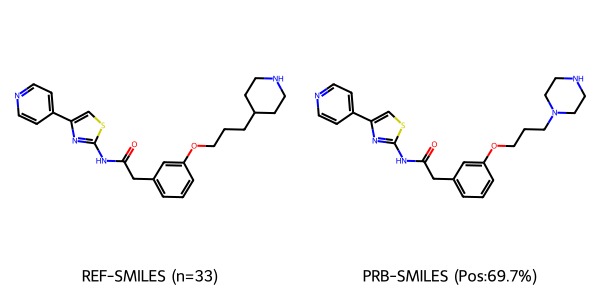

--------------------------------------------------------------------------------

Pair 2: Occurrence = 30 samples
  Positive (label=True):     25 samples ( 83.3%)
  Negative (label=False):     5 samples ( 16.7%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OC[C@@H]3CCCO3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1


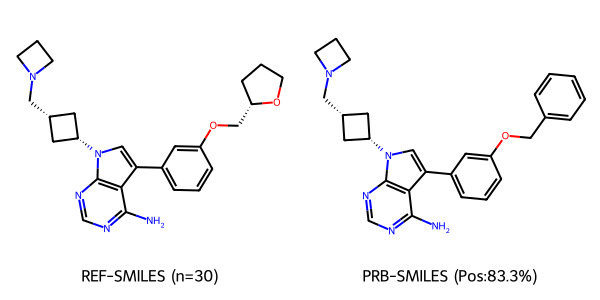

--------------------------------------------------------------------------------

Pair 3: Occurrence = 24 samples
  Positive (label=True):     22 samples ( 91.7%)
  Negative (label=False):     2 samples (  8.3%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OCC34CCC(CC3)O4)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1


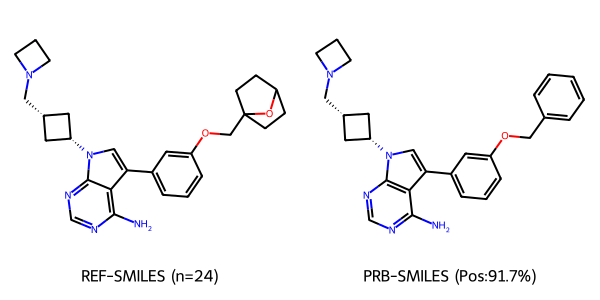

--------------------------------------------------------------------------------

Pair 4: Occurrence = 21 samples
  Positive (label=True):     19 samples ( 90.5%)
  Negative (label=False):     2 samples (  9.5%)
REF-SMILES: Nc1ncnc2c1c(-c1cccc(OCC34CCC(CC3)O4)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1
PRB-SMILES: Nc1ncnc2c1c(-c1cccc(OC[C@@H]3CCCO3)c1)cn2[C@H]1C[C@@H](CN2CCC2)C1


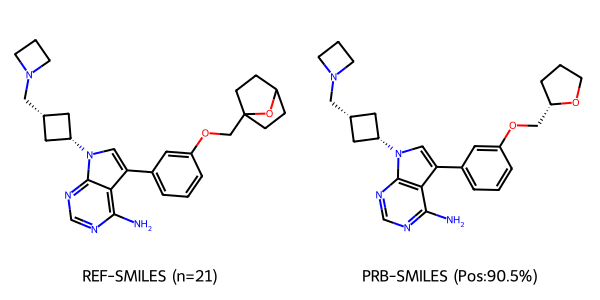

--------------------------------------------------------------------------------

Pair 5: Occurrence = 17 samples
  Positive (label=True):      1 samples (  5.9%)
  Negative (label=False):    16 samples ( 94.1%)
REF-SMILES: CC(C)C(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: COCC(=O)N1CCC[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1


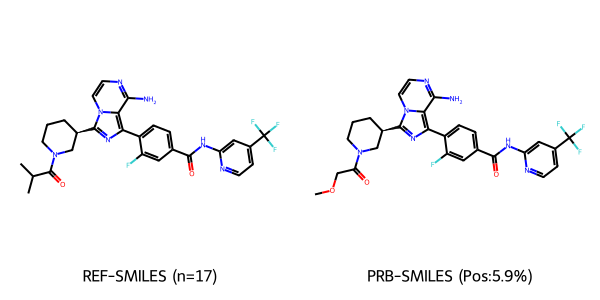

--------------------------------------------------------------------------------

Pair 6: Occurrence = 16 samples
  Positive (label=True):      4 samples ( 25.0%)
  Negative (label=False):    12 samples ( 75.0%)
REF-SMILES: CC(C)C(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: COCC(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1

Pair 6: Occurrence = 16 samples
  Positive (label=True):      4 samples ( 25.0%)
  Negative (label=False):    12 samples ( 75.0%)
REF-SMILES: CC(C)C(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1
PRB-SMILES: COCC(=O)N1CCO[C@@H](c2nc(-c3ccc(C(=O)Nc4cc(C(F)(F)F)ccn4)cc3F)c3c(N)nccn23)C1


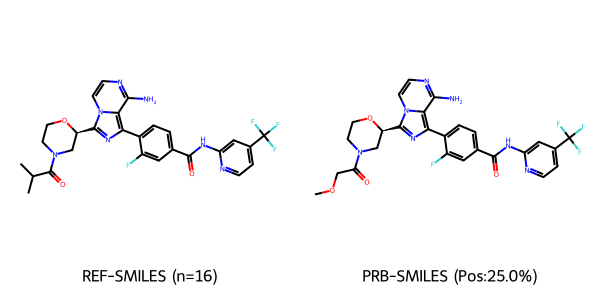

--------------------------------------------------------------------------------

Pair 7: Occurrence = 14 samples
  Positive (label=True):      8 samples ( 57.1%)
  Negative (label=False):     6 samples ( 42.9%)
REF-SMILES: CC(C)Cc1c(C(=O)C(N)=O)c2c(OCC(=O)NS(=O)(=O)c3ccccc3)cc3ccccc3c2n1Cc1ccccc1
PRB-SMILES: CC(C)Cc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cc3ccccc3c2n1Cc1ccccc1

Pair 7: Occurrence = 14 samples
  Positive (label=True):      8 samples ( 57.1%)
  Negative (label=False):     6 samples ( 42.9%)
REF-SMILES: CC(C)Cc1c(C(=O)C(N)=O)c2c(OCC(=O)NS(=O)(=O)c3ccccc3)cc3ccccc3c2n1Cc1ccccc1
PRB-SMILES: CC(C)Cc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cc3ccccc3c2n1Cc1ccccc1


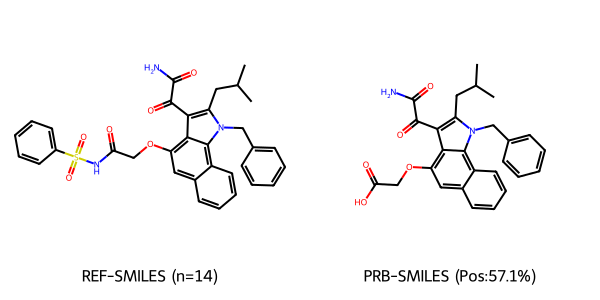

--------------------------------------------------------------------------------

Pair 8: Occurrence = 14 samples
  Positive (label=True):     10 samples ( 71.4%)
  Negative (label=False):     4 samples ( 28.6%)
REF-SMILES: CS(=O)(=O)Cc1cccc(Nc2nccc(Oc3ccc4c(C(=O)Nc5cccc(F)c5)cccc4c3)n2)c1
PRB-SMILES: CS(=O)(=O)Cc1cccc(Nc2nccc(Oc3ccc4c(C(=O)Nc5ccccc5)cccc4c3)n2)c1

Pair 8: Occurrence = 14 samples
  Positive (label=True):     10 samples ( 71.4%)
  Negative (label=False):     4 samples ( 28.6%)
REF-SMILES: CS(=O)(=O)Cc1cccc(Nc2nccc(Oc3ccc4c(C(=O)Nc5cccc(F)c5)cccc4c3)n2)c1
PRB-SMILES: CS(=O)(=O)Cc1cccc(Nc2nccc(Oc3ccc4c(C(=O)Nc5ccccc5)cccc4c3)n2)c1


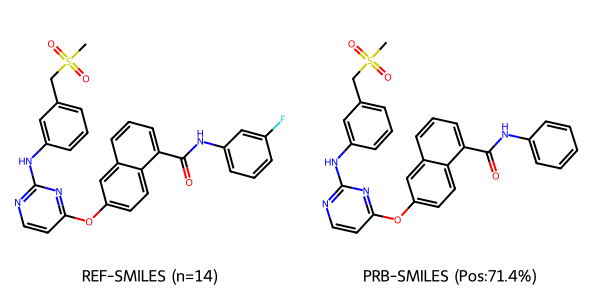

--------------------------------------------------------------------------------

Pair 9: Occurrence = 14 samples
  Positive (label=True):      7 samples ( 50.0%)
  Negative (label=False):     7 samples ( 50.0%)
REF-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cccn2c1Cc1ccccc1-c1ccccc1
PRB-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(C)=O)cccn2c1Cc1ccccc1-c1ccccc1

Pair 9: Occurrence = 14 samples
  Positive (label=True):      7 samples ( 50.0%)
  Negative (label=False):     7 samples ( 50.0%)
REF-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cccn2c1Cc1ccccc1-c1ccccc1
PRB-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(C)=O)cccn2c1Cc1ccccc1-c1ccccc1


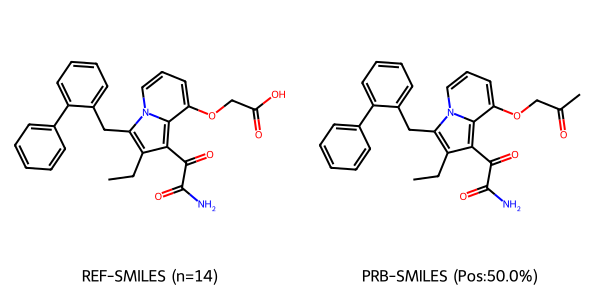

--------------------------------------------------------------------------------

Pair 10: Occurrence = 14 samples
  Positive (label=True):      1 samples (  7.1%)
  Negative (label=False):    13 samples ( 92.9%)
REF-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)NS(=O)(=O)c3ccccc3)cc3ccccc3c2n1Cc1ccccc1
PRB-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cc3ccccc3c2n1Cc1ccccc1

Pair 10: Occurrence = 14 samples
  Positive (label=True):      1 samples (  7.1%)
  Negative (label=False):    13 samples ( 92.9%)
REF-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)NS(=O)(=O)c3ccccc3)cc3ccccc3c2n1Cc1ccccc1
PRB-SMILES: CCc1c(C(=O)C(N)=O)c2c(OCC(=O)O)cc3ccccc3c2n1Cc1ccccc1


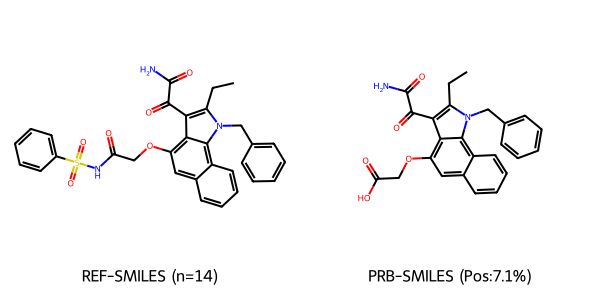

--------------------------------------------------------------------------------


In [30]:
# 最も出現頻度の高い分子ペアTop 10を可視化
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Top 10の分子ペアを抽出
top_molecule_pairs = grouped_molecule_counts.head(10).copy()

# MOLECULE_PAIRのタプルをREF-SMILESとPRB-SMILESに分解
top_molecule_pairs[['REF-SMILES', 'PRB-SMILES']] = pd.DataFrame(
    top_molecule_pairs['MOLECULE_PAIR'].tolist(), 
    index=top_molecule_pairs.index
)

print("■ Structure visualization of Top 10 most frequent molecule pairs")
print("=" * 80)

for idx, (index, row) in enumerate(top_molecule_pairs.iterrows(), 1):
    ref_smiles = row['REF-SMILES']
    prb_smiles = row['PRB-SMILES']
    count = row['count']
    mol_pair = row['MOLECULE_PAIR']
    
    # この分子ペアに対応するデータを抽出
    pair_data = df[df['MOLECULE_PAIR'] == mol_pair]
    
    # label_binの統計を計算
    n_positive = (pair_data['label_bin'] == True).sum()
    n_negative = (pair_data['label_bin'] == False).sum()
    pos_ratio = n_positive / count * 100 if count > 0 else 0
    neg_ratio = n_negative / count * 100 if count > 0 else 0
    
    print(f"\nPair {idx}: Occurrence = {count:,} samples")
    print(f"  Positive (label=True):  {n_positive:5,} samples ({pos_ratio:5.1f}%)")
    print(f"  Negative (label=False): {n_negative:5,} samples ({neg_ratio:5.1f}%)")
    print(f"REF-SMILES: {ref_smiles}")
    print(f"PRB-SMILES: {prb_smiles}")
    
    # 両方の分子を横に並べて表示
    mols = []
    legends = []
    
    # REF-SMILESを分子として解釈
    try:
        mol_ref = Chem.MolFromSmiles(ref_smiles)
        if mol_ref:
            mols.append(mol_ref)
            legends.append(f"REF-SMILES (n={count:,})")
        else:
            print("⚠ Failed to parse REF-SMILES structure")
    except Exception as e:
        print(f"⚠ REF-SMILES error: {e}")
    
    # PRB-SMILESを分子として解釈
    try:
        mol_prb = Chem.MolFromSmiles(prb_smiles)
        if mol_prb:
            mols.append(mol_prb)
            legends.append(f"PRB-SMILES (Pos:{pos_ratio:.1f}%)")
        else:
            print("⚠ Failed to parse PRB-SMILES structure")
    except Exception as e:
        print(f"⚠ PRB-SMILES error: {e}")
    
    # 2つの構造を横に並べて表示
    if len(mols) == 2:
        img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300), 
                                     legends=legends)
        display(img)
    elif len(mols) == 1:
        display(Draw.MolToImage(mols[0], size=(300, 300)))
    
    print("-" * 80)

### 4.5 サンプル数閾値の推奨値分析

文献 (J. Med. Chem. 2011, 54, 3452–3463) に基づき、各フラグメントペアについて統計的に有意な評価を行うためのサンプル数下限を検討します。

In [31]:
# 各フラグメントペアのΔpIC50統計を計算
print("■ Calculating ΔpIC50 statistics per fragment pair...")

# FRAG_PAIRごとにΔpIC50の統計量を計算
frag_pair_stats = df.groupby('FRAG_PAIR').agg({
    'delta_value': ['count', 'mean', 'std', 'min', 'max']
}).reset_index()

# カラム名を整理
frag_pair_stats.columns = ['FRAG_PAIR', 'n_samples', 'mean_delta', 'std_delta', 'min_delta', 'max_delta']
frag_pair_stats = frag_pair_stats.sort_values('n_samples', ascending=False)

print(f"Completed.")
print(f"\n■ Summary of fragment pair statistics:")
print(frag_pair_stats[['n_samples', 'mean_delta', 'std_delta']].describe())

# 各閾値でのデータ品質評価
print(f"\n■ Data quality at each threshold:")
print(f"{'Threshold':<12} {'# Pairs':<12} {'Total samples':<15} {'Avg samples':<15} {'With std (%)':<15}")
print("-" * 75)

for threshold in [1, 2, 3, 5, 10, 20]:
    filtered = frag_pair_stats[frag_pair_stats['n_samples'] >= threshold]
    n_pairs = len(filtered)
    total_samples = filtered['n_samples'].sum()
    avg_samples = filtered['n_samples'].mean()
    # 標準偏差が計算可能なペアの割合 (n≥2が必要)
    with_std = (filtered['n_samples'] >= 2).sum() if threshold <= 2 else n_pairs
    with_std_pct = with_std / n_pairs * 100 if n_pairs > 0 else 0
    
    print(f"{f'n ≥ {threshold}':<12} {n_pairs:<12,} {total_samples:<15,} {avg_samples:<15.1f} {with_std_pct:<15.1f}")

# 推奨閾値の提案
print(f"\n■ Recommended threshold suggestions:")
print(f"  • n ≥ 3: Minimal statistical evaluation possible (mean ± std)")
print(f"  • n ≥ 5: More reliable statistical evaluation")
print(f"  • n ≥ 10: Statistical tests (e.g., t-test) feasible")

# n≥3のフラグメントペアでカバーされるサンプル数
filtered_3 = frag_pair_stats[frag_pair_stats['n_samples'] >= 3]
coverage_3 = filtered_3['n_samples'].sum() / df.shape[0] * 100
print(f"\nWhen filtered by n ≥ 3:")
print(f"  • Retained fragment pairs: {len(filtered_3):,} / {len(frag_pair_stats):,} ({len(filtered_3)/len(frag_pair_stats)*100:.1f}%)")
print(f"  • Retained samples: {filtered_3['n_samples'].sum():,} / {df.shape[0]:,} ({coverage_3:.1f}%)")

■ Calculating ΔpIC50 statistics per fragment pair...
Completed.

■ Summary of fragment pair statistics:
           n_samples     mean_delta      std_delta
count  380847.000000  380847.000000  150316.000000
mean        2.045654      -0.014905       0.604158
std         5.482583       0.817345       0.527030
min         1.000000      -6.605414       0.000000
25%         1.000000      -0.357062       0.226500
50%         1.000000       0.000000       0.484851
75%         2.000000       0.335353       0.836802
max      1175.000000       4.989005       5.979247

■ Data quality at each threshold:
Threshold    # Pairs      Total samples   Avg samples     With std (%)   
---------------------------------------------------------------------------
n ≥ 1        380,847      779,081         2.0             39.5           
n ≥ 2        150,316      548,550         3.6             100.0          
n ≥ 3        89,893       427,704         4.8             100.0          
n ≥ 5        16,029       185,

### 4.4 サンプル数 vs ΔpIC50 の関係 (フラグメントペアベース)

■ Fragment pairs with sample count n≥3: 89,893 types
  (out of 380,847 total fragment pairs, 23.6%)


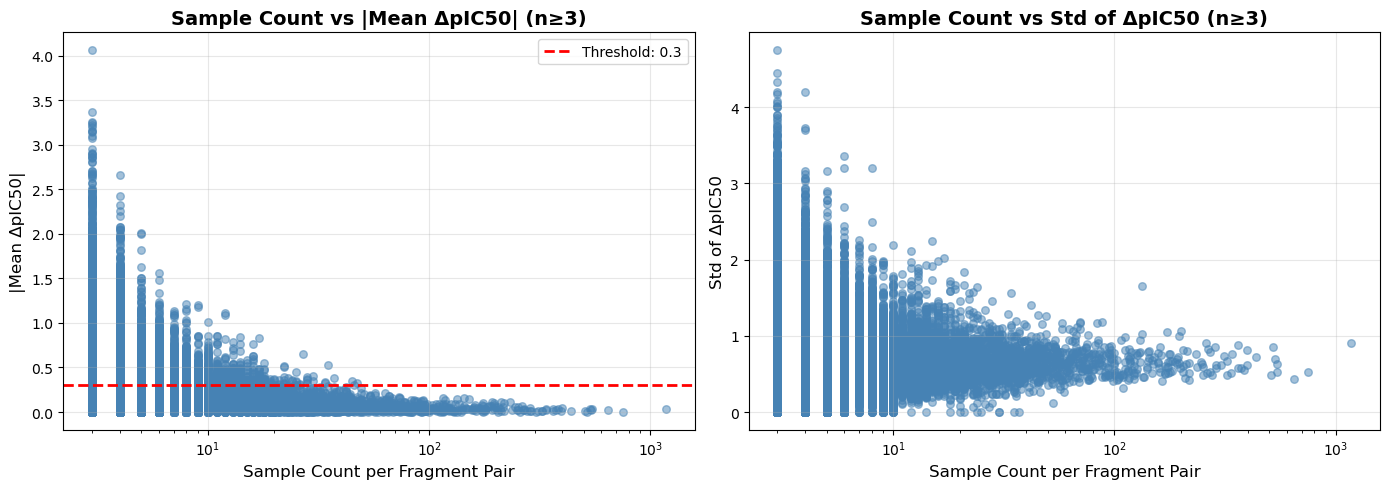

■ Figure 3: Relationship between sample count and ΔpIC50 (fragment pair-based)


In [32]:
# 各フラグメントペア(順不同)のサンプル数とΔpIC50の統計を計算
# frag_pair_statsは既にセクション4.3で計算済み

# サンプル数が3以上のものに絞る
frag_pair_stats_filtered = frag_pair_stats[frag_pair_stats['n_samples'] >= 3]

print(f"■ Fragment pairs with sample count n≥3: {len(frag_pair_stats_filtered):,} types")
print(f"  (out of {len(frag_pair_stats):,} total fragment pairs, {len(frag_pair_stats_filtered)/len(frag_pair_stats)*100:.1f}%)")

# 散布図で可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. サンプル数 vs 平均ΔpIC50の絶対値
axes[0].scatter(frag_pair_stats_filtered['n_samples'], 
                frag_pair_stats_filtered['mean_delta'].abs(), 
                alpha=0.5, s=30, color='steelblue')
axes[0].axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: 0.3')
axes[0].set_xlabel('Sample Count per Fragment Pair', fontsize=12)
axes[0].set_ylabel('|Mean ΔpIC50|', fontsize=12)
axes[0].set_title('Sample Count vs |Mean ΔpIC50| (n≥3)', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. サンプル数 vs ΔpIC50の標準偏差
axes[1].scatter(frag_pair_stats_filtered['n_samples'], 
                frag_pair_stats_filtered['std_delta'], 
                alpha=0.5, s=30, color='steelblue')
axes[1].set_xlabel('Sample Count per Fragment Pair', fontsize=12)
axes[1].set_ylabel('Std of ΔpIC50', fontsize=12)
axes[1].set_title('Sample Count vs Std of ΔpIC50 (n≥3)', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("■ Figure 3: Relationship between sample count and ΔpIC50 (fragment pair-based)")

## 5. ポジティブ/ネガティブサンプルの件数・割合



### 5.1 label_binの分布

■ Distribution of labels (label_bin):
label_bin
False    448141
True     330940
Name: count, dtype: int64

Total samples: 779,081

■ Proportion by label:
  label_bin = False: 448,141 samples (57.52%)
  label_bin = True: 330,940 samples (42.48%)


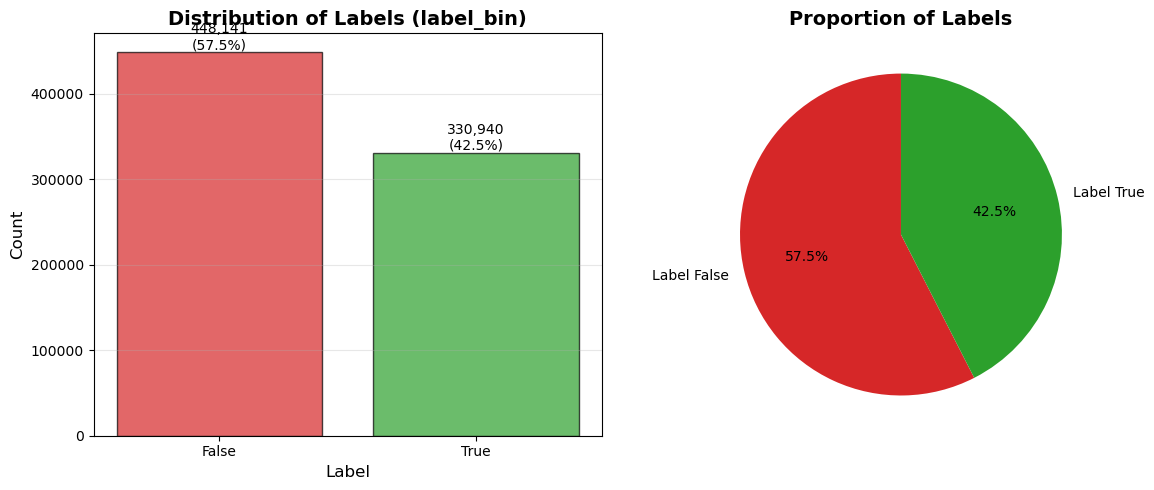

In [33]:
# label_binの分布を確認
if 'label_bin' in df.columns:
    label_counts = df['label_bin'].value_counts().sort_index()
    
    print("■ Distribution of labels (label_bin):")
    print(label_counts)
    print(f"\nTotal samples: {len(df):,}")
    
    # 割合を計算
    print("\n■ Proportion by label:")
    for label, count in label_counts.items():
        print(f"  label_bin = {label}: {count:7,} samples ({count/len(df)*100:5.2f}%)")
    
    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 棒グラフ
    axes[0].bar(label_counts.index.astype(str), label_counts.values, 
                color=['#d62728', '#2ca02c'], alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Label', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Distribution of Labels (label_bin)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, (label, count) in enumerate(label_counts.items()):
        axes[0].text(i, count, f'{count:,}\n({count/len(df)*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=10)
    
    # 円グラフ
    axes[1].pie(label_counts.values, labels=[f'Label {i}' for i in label_counts.index],
                autopct='%1.1f%%', startangle=90, colors=['#d62728', '#2ca02c'])
    axes[1].set_title('Proportion of Labels', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Warning: 'label_bin' column not found")

### 5.2 ΔpIC50の範囲別のサンプル分類

In [34]:
# ΔpIC50の範囲別にサンプルを分類
delta_abs = df['delta_value'].abs()

# カテゴリ分け
categories = {
    'Bioisostere (|Δ| < 0.3)': (delta_abs < 0.3).sum(),
    'Small difference (0.3 ≤ |Δ| < 0.5)': ((delta_abs >= 0.3) & (delta_abs < 0.5)).sum(),
    'Medium difference (0.5 ≤ |Δ| < 1.0)': ((delta_abs >= 0.5) & (delta_abs < 1.0)).sum(),
    'Large difference (1.0 ≤ |Δ| < 2.0)': ((delta_abs >= 1.0) & (delta_abs < 2.0)).sum(),
    'Very large difference (|Δ| ≥ 2.0)': (delta_abs >= 2.0).sum()
}

# 結果を表示
print("■ Sample classification by ΔpIC50 range:")
print("="*70)
category_df = pd.DataFrame([
    {'Category': k, 'Count': v, 'Percentage': f'{v/len(df)*100:.2f}%'} 
    for k, v in categories.items()
])
print(category_df.to_string(index=False))
print("="*70)
print(f"Total: {len(df):,} samples")

# Positive (Bioisostere) vs Negative の定義を明示
print("\n■ Definition of Positive / Negative samples:")
print(f"  Positive (Bioisostere):     |ΔpIC50| < 0.3   → {categories['Bioisostere (|Δ| < 0.3)']:7,} samples ({categories['Bioisostere (|Δ| < 0.3)']/len(df)*100:5.2f}%)")
print(f"  Negative (Non-bioisostere): |ΔpIC50| ≥ 0.3   → {len(df) - categories['Bioisostere (|Δ| < 0.3)']:7,} samples ({(len(df) - categories['Bioisostere (|Δ| < 0.3)'])/len(df)*100:5.2f}%)")

■ Sample classification by ΔpIC50 range:
                           Category  Count Percentage
            Bioisostere (|Δ| < 0.3) 330940     42.48%
 Small difference (0.3 ≤ |Δ| < 0.5) 118872     15.26%
Medium difference (0.5 ≤ |Δ| < 1.0) 172327     22.12%
 Large difference (1.0 ≤ |Δ| < 2.0) 129824     16.66%
  Very large difference (|Δ| ≥ 2.0)  27118      3.48%
Total: 779,081 samples

■ Definition of Positive / Negative samples:
  Positive (Bioisostere):     |ΔpIC50| < 0.3   → 330,940 samples (42.48%)
  Negative (Non-bioisostere): |ΔpIC50| ≥ 0.3   → 448,141 samples (57.52%)


### 5.3 フラグメントペアごとのラベル一貫性分析

各フラグメントペアが常にバイオアイソスター(positive)、常に非バイオアイソスター(negative)、あるいは両方が混在しているかを分析します。

In [35]:
# フラグメントペアごとのラベル（positive/negative）の一貫性を分析
# label_positiveがすでに存在する場合はそのまま使用、なければ作成
if 'label_positive' not in df.columns:
    df['label_positive'] = (df['delta_value'].abs() < 0.3).astype(int)

# フラグメントペアのキーを作成（REF-FRAG と PRB-FRAG の組み合わせ）
df['FRAG_PAIR'] = df['REF-FRAG'] + '||' + df['PRB-FRAG']

# 各フラグメントペアについて、ラベルの統計を計算
frag_pair_label_stats = df.groupby('FRAG_PAIR').agg({
    'label_positive': ['count', 'sum', 'mean']
}).reset_index()

# カラム名を整理
frag_pair_label_stats.columns = ['FRAG_PAIR', 'total_samples', 'positive_count', 'positive_ratio']
frag_pair_label_stats['negative_count'] = frag_pair_label_stats['total_samples'] - frag_pair_label_stats['positive_count']

# ラベルの一貫性を分類
# - All Positive: 全てpositive (positive_ratio == 1.0)
# - All Negative: 全てnegative (positive_ratio == 0.0)
# - Mixed: 両方が混在 (0.0 < positive_ratio < 1.0)

def classify_consistency(row):
    if row['positive_ratio'] == 1.0:
        return 'All Positive'
    elif row['positive_ratio'] == 0.0:
        return 'All Negative'
    else:
        return 'Mixed'

frag_pair_label_stats['consistency'] = frag_pair_label_stats.apply(classify_consistency, axis=1)

# 統計を表示
print("■ Label consistency analysis per fragment pair:")
print("="*80)

consistency_counts = frag_pair_label_stats['consistency'].value_counts()
print("\n【Distribution of label consistency】")
for consistency, count in consistency_counts.items():
    pct = count / len(frag_pair_label_stats) * 100
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal fragment pairs: {len(frag_pair_label_stats):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency】")
for consistency in ['All Positive', 'Mixed', 'All Negative']:
    if consistency in consistency_counts.index:
        pairs_subset = frag_pair_label_stats[frag_pair_label_stats['consistency'] == consistency]
        total_samples_in_category = pairs_subset['total_samples'].sum()
        pct = total_samples_in_category / df.shape[0] * 100
        print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples: {df.shape[0]:,}")
print("="*80)

■ Label consistency analysis per fragment pair:

【Distribution of label consistency】
  All Negative   : 306,272 pairs ( 53.9%)
  All Positive   : 192,029 pairs ( 33.8%)
  Mixed          : 69,443 pairs ( 12.2%)

Total fragment pairs: 567,744

【Sample distribution by label consistency】
  All Positive   : 236,602 samples ( 30.4%)
  Mixed          : 191,265 samples ( 24.6%)
  All Negative   : 351,214 samples ( 45.1%)

Total samples: 779,081


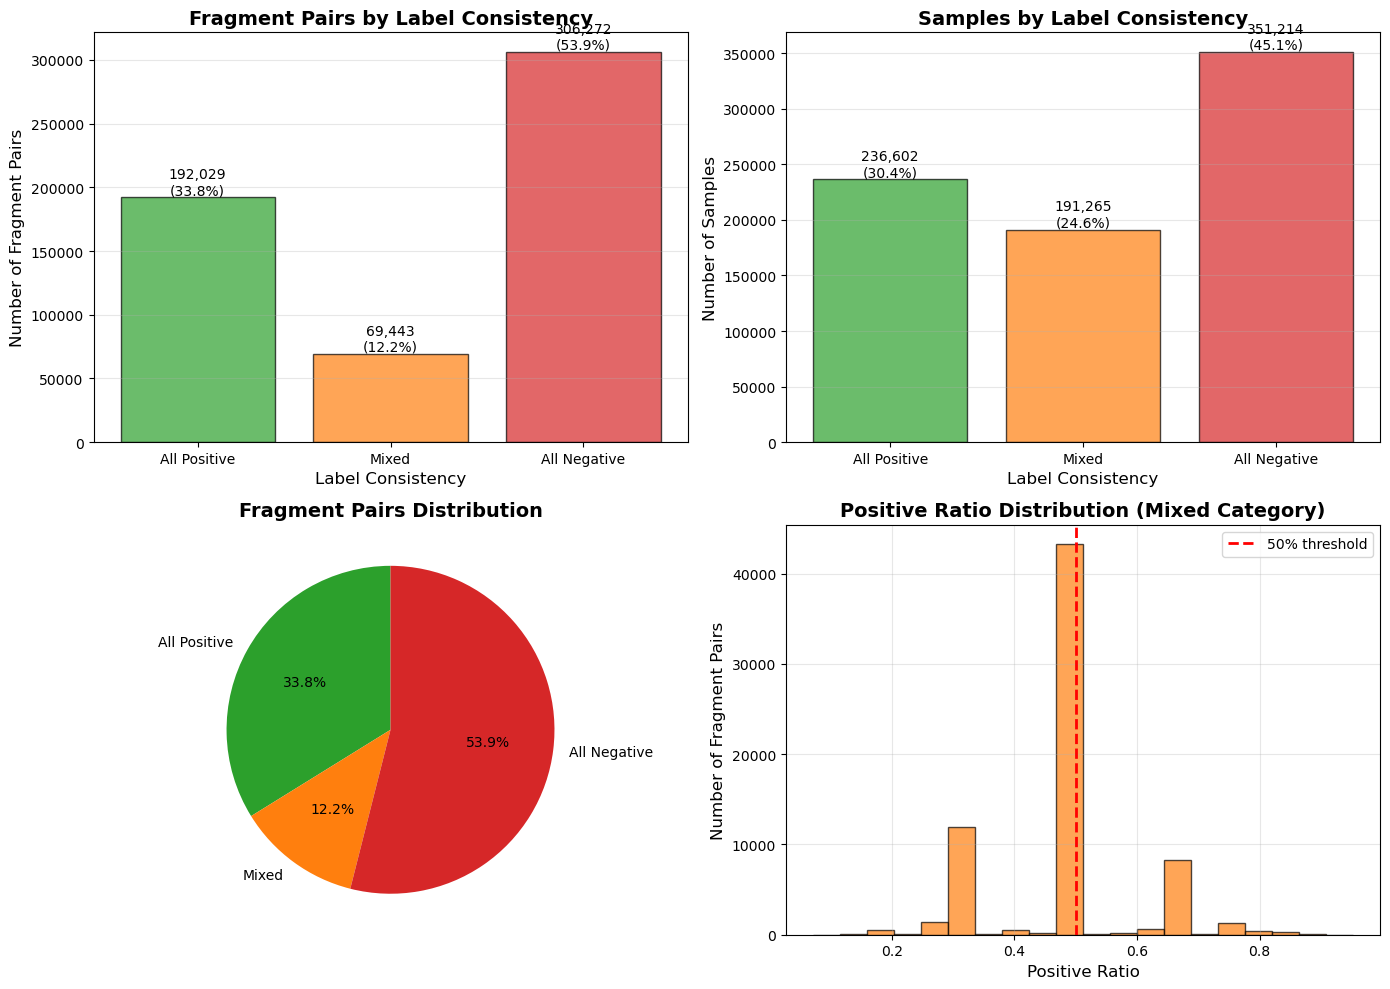

■ Figure: Label consistency analysis for fragment pairs


In [ ]:
# ラベル一貫性の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. フラグメントペア数の分布（棒グラフ）
consistency_order = ['All Positive', 'Mixed', 'All Negative']
consistency_counts_ordered = [consistency_counts.get(c, 0) for c in consistency_order]
colors = ['#2ca02c', '#ff7f0e', '#d62728']

axes[0, 0].bar(consistency_order, consistency_counts_ordered, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Label Consistency', fontsize=16)
axes[0, 0].set_ylabel('Number of Fragment Pairs', fontsize=16)
axes[0, 0].set_title('Fragment Pairs by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 0].tick_params(axis='both', labelsize=14)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, (cat, count) in enumerate(zip(consistency_order, consistency_counts_ordered)):
    axes[0, 0].text(i, count, f'{count:,}\n({count/len(frag_pair_label_stats)*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 2. サンプル数の分布（棒グラフ）
sample_counts = []
for consistency in consistency_order:
    pairs_subset = frag_pair_label_stats[frag_pair_label_stats['consistency'] == consistency]
    sample_counts.append(pairs_subset['total_samples'].sum())

axes[0, 1].bar(consistency_order, sample_counts, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Label Consistency', fontsize=16)
axes[0, 1].set_ylabel('Number of Samples', fontsize=16)
axes[0, 1].set_title('Samples by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 1].tick_params(axis='both', labelsize=14)
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, (cat, count) in enumerate(zip(consistency_order, sample_counts)):
    axes[0, 1].text(i, count, f'{count:,}\n({count/df.shape[0]*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 3. 円グラフ（フラグメントペア数）
axes[1, 0].pie(consistency_counts_ordered, labels=consistency_order, autopct='%1.1f%%',
                startangle=90, colors=colors, textprops={'fontsize': 14})
axes[1, 0].set_title('Fragment Pairs Distribution', fontsize=18, fontweight='bold')

# 4. Mixedカテゴリの詳細（positive_ratioのヒストグラム）
mixed_pairs = frag_pair_label_stats[frag_pair_label_stats['consistency'] == 'Mixed']
if len(mixed_pairs) > 0:
    axes[1, 1].hist(mixed_pairs['positive_ratio'], bins=20, 
                    alpha=0.7, color='#ff7f0e', edgecolor='black')
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[1, 1].set_xlabel('Positive Ratio', fontsize=16)
    axes[1, 1].set_ylabel('Number of Fragment Pairs', fontsize=16)
    axes[1, 1].set_title('Positive Ratio Distribution (Mixed Category)', fontsize=18, fontweight='bold')
    axes[1, 1].tick_params(axis='both', labelsize=14)
    axes[1, 1].legend(fontsize=13)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No Mixed pairs found', 
                    ha='center', va='center', fontsize=16)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("■ Figure: Label consistency analysis for fragment pairs")

In [37]:
# サンプル数による分析（n≥3のフラグメントペアのみ）
frag_pair_label_stats_filtered = frag_pair_label_stats[frag_pair_label_stats['total_samples'] >= 3]

print("\n■ Label consistency analysis (n≥3 samples per fragment pair):")
print("="*80)

consistency_counts_filtered = frag_pair_label_stats_filtered['consistency'].value_counts()
print("\n【Distribution of label consistency (n≥3)】")
for consistency in consistency_order:
    count = consistency_counts_filtered.get(consistency, 0)
    pct = count / len(frag_pair_label_stats_filtered) * 100 if len(frag_pair_label_stats_filtered) > 0 else 0
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal fragment pairs (n≥3): {len(frag_pair_label_stats_filtered):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency (n≥3)】")
for consistency in consistency_order:
    pairs_subset = frag_pair_label_stats_filtered[frag_pair_label_stats_filtered['consistency'] == consistency]
    total_samples_in_category = pairs_subset['total_samples'].sum()
    pct = total_samples_in_category / frag_pair_label_stats_filtered['total_samples'].sum() * 100
    print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples (n≥3): {frag_pair_label_stats_filtered['total_samples'].sum():,}")
print("="*80)


■ Label consistency analysis (n≥3 samples per fragment pair):

【Distribution of label consistency (n≥3)】
  All Positive   :  8,384 pairs ( 19.9%)
  Mixed          : 28,017 pairs ( 66.5%)
  All Negative   :  5,704 pairs ( 13.5%)

Total fragment pairs (n≥3): 42,105

【Sample distribution by label consistency (n≥3)】
  All Positive   :  27,912 samples ( 18.0%)
  Mixed          : 108,413 samples ( 70.0%)
  All Negative   :  18,550 samples ( 12.0%)

Total samples (n≥3): 154,875


### 5.4 分子ペア（順不同）ごとのラベル一貫性分析

分子ペアを順不同（A-BとB-Aを同じペアとして扱う）で集約し、各ペアのラベル一貫性を分析します。

In [38]:
# 分子ペア（順不同）ごとのラベル一貫性を分析
# REF-SMILESとPRB-SMILESを順不同にするため、辞書順でソートした組み合わせをキーとする

def create_unordered_pair_key(row):
    """REF-SMILESとPRB-SMILESを辞書順でソートしてペアキーを作成"""
    smiles_pair = tuple(sorted([row['REF-SMILES'], row['PRB-SMILES']]))
    return f"{smiles_pair[0]}||{smiles_pair[1]}"

# 順不同の分子ペアキーを作成
df['molecule_pair_unordered'] = df.apply(create_unordered_pair_key, axis=1)

# 各分子ペア（順不同）について、ラベルの統計を計算
mol_pair_label_stats = df.groupby('molecule_pair_unordered').agg({
    'label_positive': ['count', 'sum', 'mean'],
    'REF-SMILES': 'first',  # ペアの代表として保持
    'PRB-SMILES': 'first'
}).reset_index()

# カラム名を整理
mol_pair_label_stats.columns = ['molecule_pair_unordered', 'total_samples', 'positive_count', 'positive_ratio', 'REF_SMILES_rep', 'PRB_SMILES_rep']
mol_pair_label_stats['negative_count'] = mol_pair_label_stats['total_samples'] - mol_pair_label_stats['positive_count']

# ラベルの一貫性を分類
mol_pair_label_stats['consistency'] = mol_pair_label_stats.apply(classify_consistency, axis=1)

# 統計を表示
print("■ Label consistency analysis per molecule pair (unordered):")
print("="*80)

mol_consistency_counts = mol_pair_label_stats['consistency'].value_counts()
print("\n【Distribution of label consistency】")
for consistency, count in mol_consistency_counts.items():
    pct = count / len(mol_pair_label_stats) * 100
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal molecule pairs (unordered): {len(mol_pair_label_stats):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency】")
for consistency in ['All Positive', 'Mixed', 'All Negative']:
    if consistency in mol_consistency_counts.index:
        pairs_subset = mol_pair_label_stats[mol_pair_label_stats['consistency'] == consistency]
        total_samples_in_category = pairs_subset['total_samples'].sum()
        pct = total_samples_in_category / df.shape[0] * 100
        print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples: {df.shape[0]:,}")
print("="*80)

■ Label consistency analysis per molecule pair (unordered):

【Distribution of label consistency】
  All Negative   : 273,986 pairs ( 52.6%)
  All Positive   : 165,209 pairs ( 31.7%)
  Mixed          : 82,027 pairs ( 15.7%)

Total molecule pairs (unordered): 521,222

【Sample distribution by label consistency】
  All Positive   : 220,651 samples ( 28.3%)
  Mixed          : 230,056 samples ( 29.5%)
  All Negative   : 328,374 samples ( 42.1%)

Total samples: 779,081


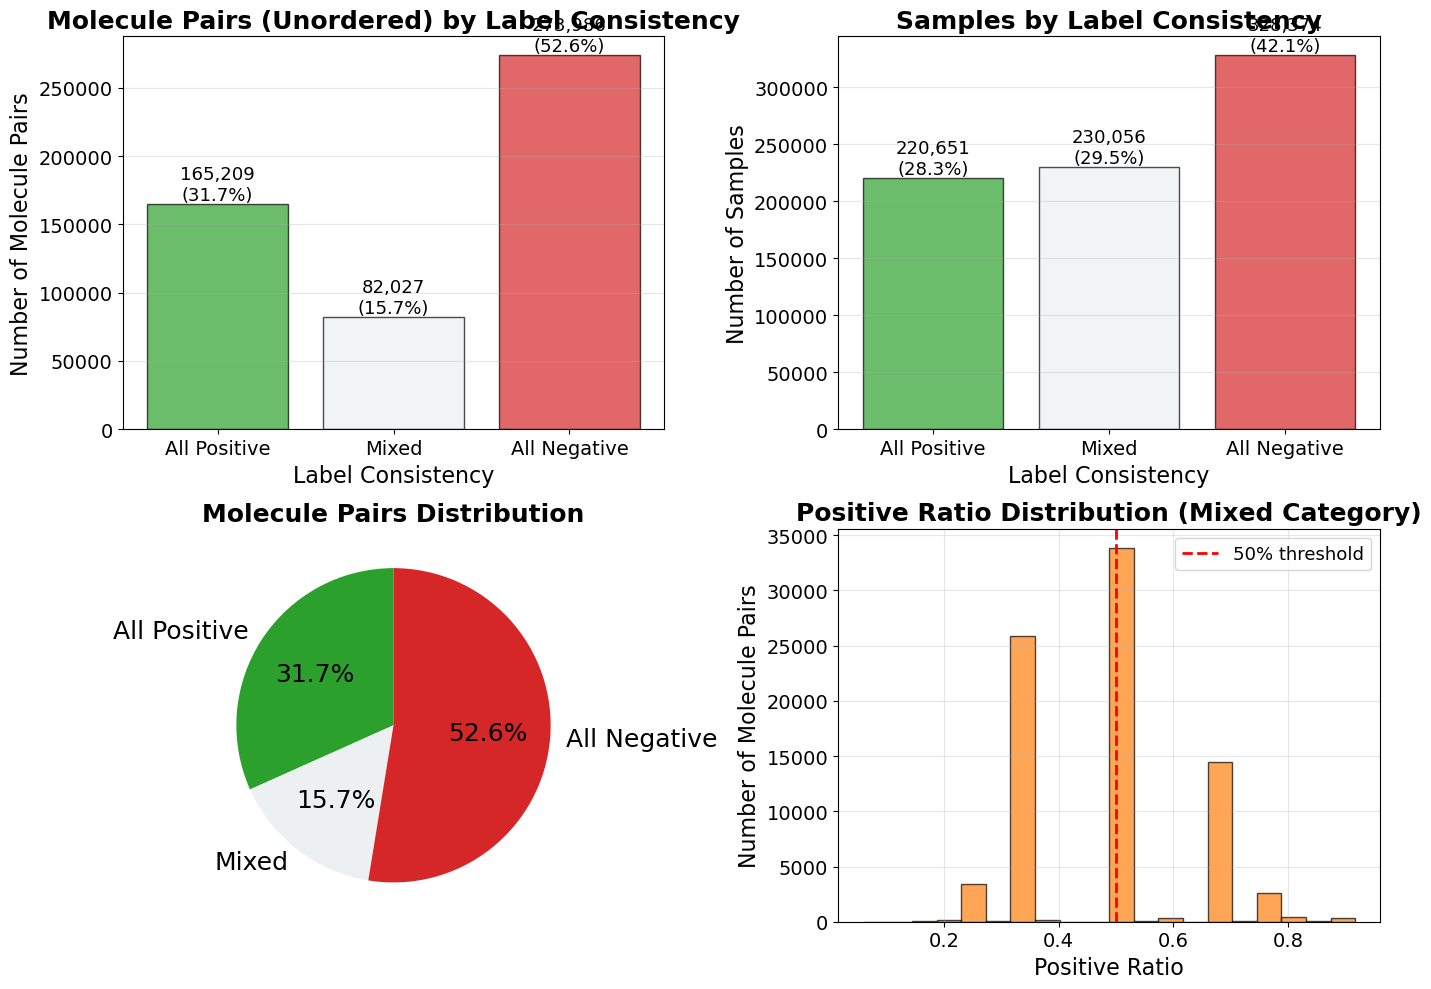

■ Figure: Label consistency analysis for molecule pairs (unordered)


In [64]:
# 分子ペア（順不同）のラベル一貫性の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 分子ペア数の分布（棒グラフ）
mol_consistency_counts_ordered = [mol_consistency_counts.get(c, 0) for c in consistency_order]
colors = ['#2ca02c', '#ecf0f1', '#d62728']

axes[0, 0].bar(consistency_order, mol_consistency_counts_ordered, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Label Consistency', fontsize=16)
axes[0, 0].set_ylabel('Number of Molecule Pairs', fontsize=16)
axes[0, 0].set_title('Molecule Pairs (Unordered) by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 0].tick_params(axis='both', labelsize=14)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, (cat, count) in enumerate(zip(consistency_order, mol_consistency_counts_ordered)):
    axes[0, 0].text(i, count, f'{count:,}\n({count/len(mol_pair_label_stats)*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 2. サンプル数の分布（棒グラフ）
mol_sample_counts = []
for consistency in consistency_order:
    pairs_subset = mol_pair_label_stats[mol_pair_label_stats['consistency'] == consistency]
    mol_sample_counts.append(pairs_subset['total_samples'].sum())

axes[0, 1].bar(consistency_order, mol_sample_counts, 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Label Consistency', fontsize=16)
axes[0, 1].set_ylabel('Number of Samples', fontsize=16)
axes[0, 1].set_title('Samples by Label Consistency', fontsize=18, fontweight='bold')
axes[0, 1].tick_params(axis='both', labelsize=14)
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, (cat, count) in enumerate(zip(consistency_order, mol_sample_counts)):
    axes[0, 1].text(i, count, f'{count:,}\n({count/df.shape[0]*100:.1f}%)', 
                     ha='center', va='bottom', fontsize=13)

# 3. 円グラフ（分子ペア数）
axes[1, 0].pie(mol_consistency_counts_ordered, labels=consistency_order, autopct='%1.1f%%',
                startangle=90, colors=colors, textprops={'fontsize': 18})
axes[1, 0].set_title('Molecule Pairs Distribution', fontsize=18, fontweight='bold')

# 4. Mixedカテゴリの詳細（positive_ratioのヒストグラム）
mol_mixed_pairs = mol_pair_label_stats[mol_pair_label_stats['consistency'] == 'Mixed']
if len(mol_mixed_pairs) > 0:
    axes[1, 1].hist(mol_mixed_pairs['positive_ratio'], bins=20, 
                    alpha=0.7, color='#ff7f0e', edgecolor='black')
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[1, 1].set_xlabel('Positive Ratio', fontsize=16)
    axes[1, 1].set_ylabel('Number of Molecule Pairs', fontsize=16)
    axes[1, 1].set_title('Positive Ratio Distribution (Mixed Category)', fontsize=18, fontweight='bold')
    axes[1, 1].tick_params(axis='both', labelsize=14)
    axes[1, 1].legend(fontsize=13)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No Mixed pairs found', 
                    ha='center', va='center', fontsize=16)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("■ Figure: Label consistency analysis for molecule pairs (unordered)")


■ Label consistency analysis for molecule pairs (unordered, n≥3):

【Distribution of label consistency (n≥3)】
  All Positive   : 15,175 pairs ( 20.3%)
  Mixed          : 50,936 pairs ( 68.0%)
  All Negative   :  8,777 pairs ( 11.7%)

Total molecule pairs (unordered, n≥3): 74,888

【Sample distribution by label consistency (n≥3)】
  All Positive   :  53,526 samples ( 21.4%)
  Mixed          : 167,874 samples ( 67.2%)
  All Negative   :  28,550 samples ( 11.4%)

Total samples (n≥3): 249,950


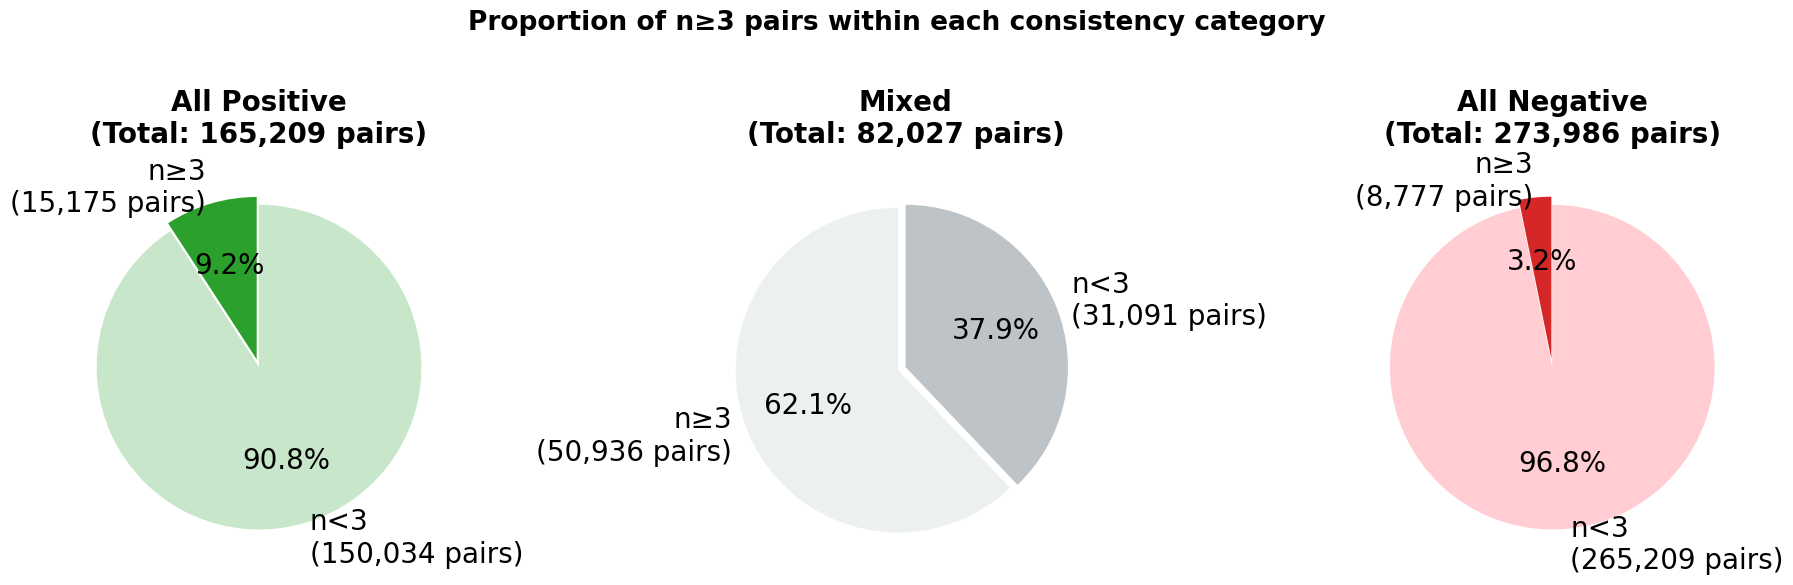


■ Figure: Proportion of n≥3 pairs in each label consistency category


In [61]:
# サンプル数による分析（n≥3の分子ペアのみ）
mol_pair_label_stats_filtered = mol_pair_label_stats[mol_pair_label_stats['total_samples'] >= 3]

print("\n■ Label consistency analysis for molecule pairs (unordered, n≥3):")
print("="*80)

mol_consistency_counts_filtered = mol_pair_label_stats_filtered['consistency'].value_counts()
print("\n【Distribution of label consistency (n≥3)】")
for consistency in consistency_order:
    count = mol_consistency_counts_filtered.get(consistency, 0)
    pct = count / len(mol_pair_label_stats_filtered) * 100 if len(mol_pair_label_stats_filtered) > 0 else 0
    print(f"  {consistency:15s}: {count:6,} pairs ({pct:5.1f}%)")

print(f"\nTotal molecule pairs (unordered, n≥3): {len(mol_pair_label_stats_filtered):,}")

# サンプル数でも集計
print("\n【Sample distribution by label consistency (n≥3)】")
for consistency in consistency_order:
    pairs_subset = mol_pair_label_stats_filtered[mol_pair_label_stats_filtered['consistency'] == consistency]
    total_samples_in_category = pairs_subset['total_samples'].sum()
    total = mol_pair_label_stats_filtered['total_samples'].sum()
    pct = total_samples_in_category / total * 100 if total > 0 else 0
    print(f"  {consistency:15s}: {total_samples_in_category:7,} samples ({pct:5.1f}%)")

print(f"\nTotal samples (n≥3): {mol_pair_label_stats_filtered['total_samples'].sum():,}")
print("="*80)

# 各カテゴリ内でn≥3のペアの割合を円グラフで可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# カテゴリごとの色設定
colors_by_category = {
    'All Positive': ['#2ca02c', '#c8e6c9'],  # 濃い緑、薄い緑
    'Mixed': ['#ecf0f1', '#bdc3c7'],  # 既存の色を維持
    'All Negative': ['#d62728', '#ffcdd2']  # 濃い赤、薄い赤
}

for idx, consistency in enumerate(consistency_order):
    # 各カテゴリ内のペアを抽出
    category_all_pairs = mol_pair_label_stats[mol_pair_label_stats['consistency'] == consistency]
    category_filtered_pairs = mol_pair_label_stats_filtered[mol_pair_label_stats_filtered['consistency'] == consistency]
    
    # n<3とn≥3のペア数を計算
    n_ge_3 = len(category_filtered_pairs)
    n_lt_3 = len(category_all_pairs) - n_ge_3
    
    # 円グラフのデータ
    sizes = [n_ge_3, n_lt_3]
    labels = [f'n≥3\n({n_ge_3:,} pairs)', f'n<3\n({n_lt_3:,} pairs)']
    colors_pie = colors_by_category[consistency]
    explode = (0.05, 0)
    
    # 全体に対する割合を計算
    total_in_category = len(category_all_pairs)
    pct_ge_3 = (n_ge_3 / total_in_category * 100) if total_in_category > 0 else 0
    
    # 円グラフを描画
    if total_in_category > 0:
        axes[idx].pie(sizes, labels=labels, autopct='%1.1f%%',
                      startangle=90, colors=colors_pie, explode=explode,
                      textprops={'fontsize': 20})
        axes[idx].set_title(f'{consistency}\n(Total: {total_in_category:,} pairs)', 
                           fontsize=20, fontweight='bold', pad=15)
    else:
        axes[idx].text(0.5, 0.5, f'No {consistency} pairs', 
                      ha='center', va='center', fontsize=18)
        axes[idx].set_title(f'{consistency}\n(Total: 0 pairs)', 
                           fontsize=20, fontweight='bold', pad=15)
        axes[idx].axis('off')

plt.suptitle('Proportion of n≥3 pairs within each consistency category', 
             fontsize=19, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n■ Figure: Proportion of n≥3 pairs in each label consistency category")

In [53]:
# フラグメントペアと分子ペア（順不同）の比較
print("\n■ Comparison: Fragment Pairs vs Molecule Pairs (Unordered):")
print("="*80)

# 基本統計の比較
comparison_data = {
    'Metric': [
        'Total pairs',
        'All Positive pairs',
        'All Negative pairs',
        'Mixed pairs',
        'All Positive %',
        'All Negative %',
        'Mixed %'
    ],
    'Fragment Pairs': [
        len(frag_pair_label_stats),
        consistency_counts.get('All Positive', 0),
        consistency_counts.get('All Negative', 0),
        consistency_counts.get('Mixed', 0),
        f"{consistency_counts.get('All Positive', 0) / len(frag_pair_label_stats) * 100:.1f}%",
        f"{consistency_counts.get('All Negative', 0) / len(frag_pair_label_stats) * 100:.1f}%",
        f"{consistency_counts.get('Mixed', 0) / len(frag_pair_label_stats) * 100:.1f}%"
    ],
    'Molecule Pairs (Unordered)': [
        len(mol_pair_label_stats),
        mol_consistency_counts.get('All Positive', 0),
        mol_consistency_counts.get('All Negative', 0),
        mol_consistency_counts.get('Mixed', 0),
        f"{mol_consistency_counts.get('All Positive', 0) / len(mol_pair_label_stats) * 100:.1f}%",
        f"{mol_consistency_counts.get('All Negative', 0) / len(mol_pair_label_stats) * 100:.1f}%",
        f"{mol_consistency_counts.get('Mixed', 0) / len(mol_pair_label_stats) * 100:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n【Comparison Table】")
print(comparison_df.to_string(index=False))
print("="*80)

# Mixedペアの詳細比較
print("\n【Mixed Pairs Details】")
if len(mixed_pairs) > 0:
    frag_mixed_stats = {
        'Mean positive ratio': mixed_pairs['positive_ratio'].mean(),
        'Median positive ratio': mixed_pairs['positive_ratio'].median(),
        'Std positive ratio': mixed_pairs['positive_ratio'].std()
    }
    print("\nFragment Pairs (Mixed):")
    for key, val in frag_mixed_stats.items():
        print(f"  {key:25s}: {val:.4f}")
    
if len(mol_mixed_pairs) > 0:
    mol_mixed_stats = {
        'Mean positive ratio': mol_mixed_pairs['positive_ratio'].mean(),
        'Median positive ratio': mol_mixed_pairs['positive_ratio'].median(),
        'Std positive ratio': mol_mixed_pairs['positive_ratio'].std()
    }
    print("\nMolecule Pairs (Mixed, Unordered):")
    for key, val in mol_mixed_stats.items():
        print(f"  {key:25s}: {val:.4f}")

print("="*80)


■ Comparison: Fragment Pairs vs Molecule Pairs (Unordered):

【Comparison Table】
            Metric Fragment Pairs Molecule Pairs (Unordered)
       Total pairs         567744                     521222
All Positive pairs         192029                     165209
All Negative pairs         306272                     273986
       Mixed pairs          69443                      82027
    All Positive %          33.8%                      31.7%
    All Negative %          53.9%                      52.6%
           Mixed %          12.2%                      15.7%

【Mixed Pairs Details】

Fragment Pairs (Mixed):
  Mean positive ratio      : 0.4923
  Median positive ratio    : 0.5000
  Std positive ratio       : 0.1135

Molecule Pairs (Mixed, Unordered):
  Mean positive ratio      : 0.4771
  Median positive ratio    : 0.5000
  Std positive ratio       : 0.1391


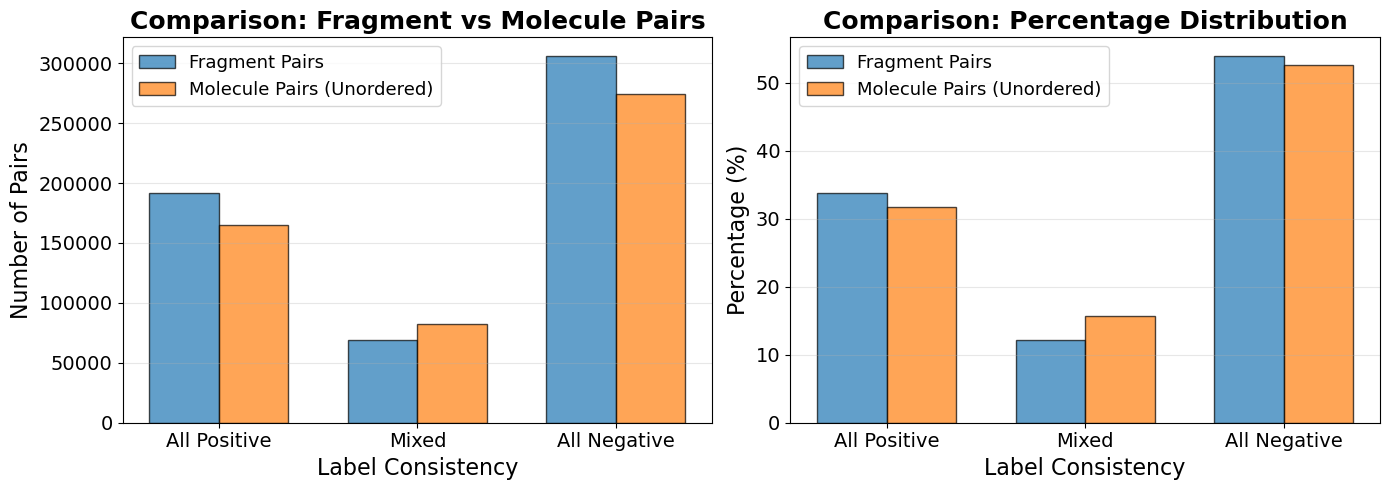

■ Figure: Comparison between fragment pairs and molecule pairs (unordered)


In [54]:
# フラグメントペアと分子ペアの比較可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. ペア数の比較（棒グラフ）
x = np.arange(len(consistency_order))
width = 0.35

frag_counts = [consistency_counts.get(c, 0) for c in consistency_order]
mol_counts = [mol_consistency_counts.get(c, 0) for c in consistency_order]

axes[0].bar(x - width/2, frag_counts, width, label='Fragment Pairs', 
            alpha=0.7, edgecolor='black', color='#1f77b4')
axes[0].bar(x + width/2, mol_counts, width, label='Molecule Pairs (Unordered)', 
            alpha=0.7, edgecolor='black', color='#ff7f0e')

axes[0].set_xlabel('Label Consistency', fontsize=16)
axes[0].set_ylabel('Number of Pairs', fontsize=16)
axes[0].set_title('Comparison: Fragment vs Molecule Pairs', fontsize=18, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(consistency_order, rotation=0, fontsize=14)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].legend(fontsize=13)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. 割合の比較（棒グラフ）
frag_pcts = [consistency_counts.get(c, 0) / len(frag_pair_label_stats) * 100 for c in consistency_order]
mol_pcts = [mol_consistency_counts.get(c, 0) / len(mol_pair_label_stats) * 100 for c in consistency_order]

axes[1].bar(x - width/2, frag_pcts, width, label='Fragment Pairs', 
            alpha=0.7, edgecolor='black', color='#1f77b4')
axes[1].bar(x + width/2, mol_pcts, width, label='Molecule Pairs (Unordered)', 
            alpha=0.7, edgecolor='black', color='#ff7f0e')

axes[1].set_xlabel('Label Consistency', fontsize=16)
axes[1].set_ylabel('Percentage (%)', fontsize=16)
axes[1].set_title('Comparison: Percentage Distribution', fontsize=18, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(consistency_order, rotation=0, fontsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].legend(fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("■ Figure: Comparison between fragment pairs and molecule pairs (unordered)")


■ Representative examples of each consistency category:

【All Positive】 (Top 3 by sample count)

  Example 1:
    Fragment pair: REF: [
                   PRB: 2
    Total samples: 18
    Positive: 18 (100.0%), Negative: 0 (0.0%)
    ⚠ Failed to parse REF-FRAG structure
    ⚠ Failed to parse PRB-FRAG structure
    ----------------------------------------------------------------------------

  Example 2:
    Fragment pair: REF: [
                   PRB: 2
    Total samples: 17
    Positive: 17 (100.0%), Negative: 0 (0.0%)
    ⚠ Failed to parse REF-FRAG structure
    ⚠ Failed to parse PRB-FRAG structure
    ----------------------------------------------------------------------------

  Example 3:
    Fragment pair: REF: [
                   PRB: 8
    Total samples: 17
    Positive: 17 (100.0%), Negative: 0 (0.0%)
    ⚠ Failed to parse REF-FRAG structure
    ⚠ Failed to parse PRB-FRAG structure
    ----------------------------------------------------------------------------
------------

[23:17:35] SMILES Parse Error: syntax error while parsing: [
[23:17:36] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[23:17:36] SMILES Parse Error: syntax error while parsing: 2
[23:17:36] SMILES Parse Error: Failed parsing SMILES '2' for input: '2'
[23:17:36] SMILES Parse Error: syntax error while parsing: [
[23:17:36] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[23:17:36] SMILES Parse Error: syntax error while parsing: 2
[23:17:36] SMILES Parse Error: Failed parsing SMILES '2' for input: '2'
[23:17:36] SMILES Parse Error: syntax error while parsing: [
[23:17:36] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[23:17:36] SMILES Parse Error: syntax error while parsing: 8
[23:17:36] SMILES Parse Error: Failed parsing SMILES '8' for input: '8'


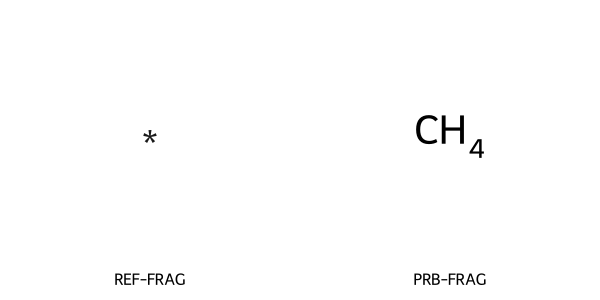

    ----------------------------------------------------------------------------

  Example 2:
    Fragment pair: REF: *
                   PRB: C
    Total samples: 376
    Positive: 218 (58.0%), Negative: 158 (42.0%)


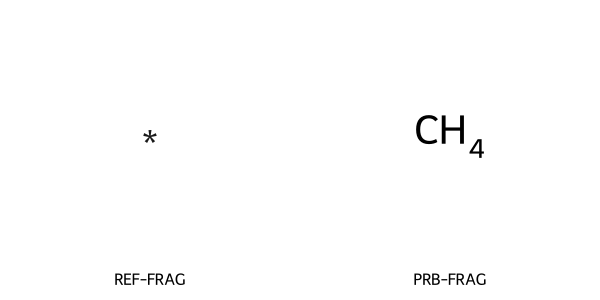

    ----------------------------------------------------------------------------

  Example 3:
    Fragment pair: REF: *
                   PRB: N
    Total samples: 207
    Positive: 69 (33.3%), Negative: 138 (66.7%)


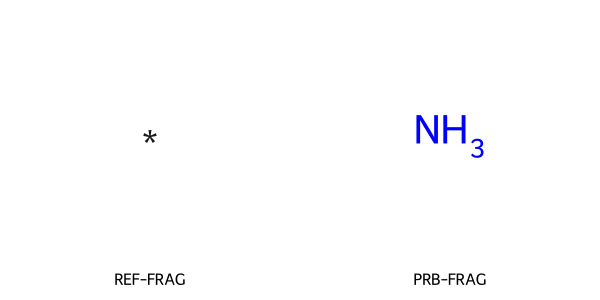

    ----------------------------------------------------------------------------
--------------------------------------------------------------------------------

【All Negative】 (Top 3 by sample count)

  Example 1:
    Fragment pair: REF: [
                   PRB: 2
    Total samples: 14
    Positive: 0 (0.0%), Negative: 14 (100.0%)
    ⚠ Failed to parse REF-FRAG structure
    ⚠ Failed to parse PRB-FRAG structure
    ----------------------------------------------------------------------------

  Example 2:
    Fragment pair: REF: [
                   PRB: 7
    Total samples: 13
    Positive: 0 (0.0%), Negative: 13 (100.0%)
    ⚠ Failed to parse REF-FRAG structure
    ⚠ Failed to parse PRB-FRAG structure
    ----------------------------------------------------------------------------

  Example 3:
    Fragment pair: REF: [
                   PRB: 4
    Total samples: 12
    Positive: 0 (0.0%), Negative: 12 (100.0%)
    ⚠ Failed to parse REF-FRAG structure
    ⚠ Failed to parse PRB-FRA

[23:17:36] SMILES Parse Error: syntax error while parsing: [
[23:17:36] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[23:17:36] SMILES Parse Error: syntax error while parsing: 2
[23:17:36] SMILES Parse Error: Failed parsing SMILES '2' for input: '2'
[23:17:36] SMILES Parse Error: syntax error while parsing: [
[23:17:36] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[23:17:36] SMILES Parse Error: syntax error while parsing: 7
[23:17:36] SMILES Parse Error: Failed parsing SMILES '7' for input: '7'
[23:17:36] SMILES Parse Error: syntax error while parsing: [
[23:17:36] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[23:17:36] SMILES Parse Error: syntax error while parsing: 4
[23:17:36] SMILES Parse Error: Failed parsing SMILES '4' for input: '4'


In [43]:
# 各カテゴリの代表例を表示（構造式付き）
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

print("\n■ Representative examples of each consistency category:")
print("="*80)

for consistency in consistency_order:
    subset = frag_pair_label_stats_filtered[frag_pair_label_stats_filtered['consistency'] == consistency]
    if len(subset) > 0:
        # サンプル数が多い順にTop 3を表示
        top_examples = subset.nlargest(3, 'total_samples')
        
        print(f"\n【{consistency}】 (Top 3 by sample count)")
        
        for idx, (_, row) in enumerate(top_examples.iterrows(), 1):
            frag_pair = row['FRAG_PAIR']
            total = row['total_samples']
            pos_count = row['positive_count']
            neg_count = row['negative_count']
            pos_ratio = row['positive_ratio']
            
            # フラグメントを取得
            ref_frag = frag_pair[0]
            prb_frag = frag_pair[1]
            
            print(f"\n  Example {idx}:")
            print(f"    Fragment pair: REF: {ref_frag[:60]}{'...' if len(ref_frag) > 60 else ''}")
            print(f"                   PRB: {prb_frag[:60]}{'...' if len(prb_frag) > 60 else ''}")
            print(f"    Total samples: {total}")
            print(f"    Positive: {pos_count} ({pos_ratio*100:.1f}%), Negative: {neg_count} ({(1-pos_ratio)*100:.1f}%)")
            
            # 構造式を可視化
            mols = []
            legends = []
            
            # REF-FRAGを分子として解釈
            try:
                mol_ref = Chem.MolFromSmiles(ref_frag)
                if mol_ref:
                    mols.append(mol_ref)
                    legends.append(f"REF-FRAG")
                else:
                    print("    ⚠ Failed to parse REF-FRAG structure")
            except Exception as e:
                print(f"    ⚠ REF-FRAG error: {e}")
            
            # PRB-FRAGを分子として解釈
            try:
                mol_prb = Chem.MolFromSmiles(prb_frag)
                if mol_prb:
                    mols.append(mol_prb)
                    legends.append(f"PRB-FRAG")
                else:
                    print("    ⚠ Failed to parse PRB-FRAG structure")
            except Exception as e:
                print(f"    ⚠ PRB-FRAG error: {e}")
            
            # 2つの構造を横に並べて表示
            if len(mols) == 2:
                img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300, 300), 
                                             legends=legends)
                display(img)
            elif len(mols) == 1:
                img = Draw.MolToImage(mols[0], size=(300, 300))
                display(img)
            
            print("    " + "-"*76)
    else:
        print(f"\n【{consistency}】")
        print(f"  No examples found")
    print("-"*80)


■ Relationship between consistency and sample count:


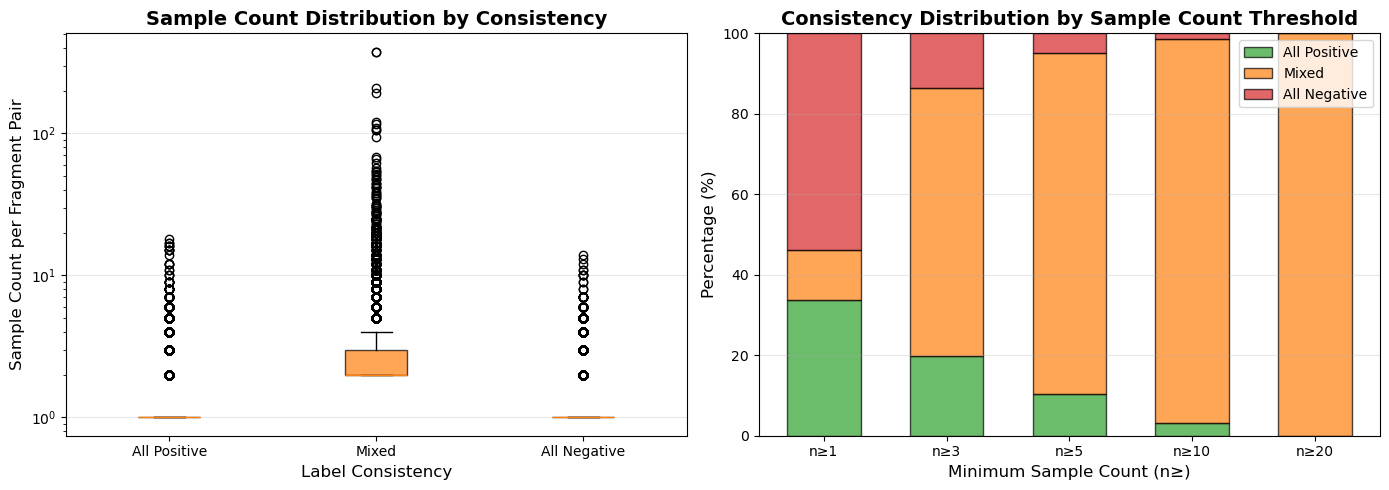


【Consistency percentage by sample count threshold】
Threshold      All Positive          Mixed   All Negative
------------------------------------------------------------
n≥1                   33.8%          12.2%          53.9%
n≥3                   19.9%          66.5%          13.5%
n≥5                   10.5%          84.7%           4.9%
n≥10                   3.1%          95.5%           1.4%
n≥20                   0.0%         100.0%           0.0%


In [44]:
# 一貫性とサンプル数の関係を分析
print("\n■ Relationship between consistency and sample count:")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 各カテゴリのサンプル数分布（ボックスプロット）
consistency_data = []
consistency_labels = []
for consistency in consistency_order:
    subset = frag_pair_label_stats[frag_pair_label_stats['consistency'] == consistency]
    if len(subset) > 0:
        consistency_data.append(subset['total_samples'].values)
        consistency_labels.append(consistency)

if consistency_data:
    bp = axes[0].boxplot(consistency_data, labels=consistency_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:len(consistency_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[0].set_xlabel('Label Consistency', fontsize=12)
    axes[0].set_ylabel('Sample Count per Fragment Pair', fontsize=12)
    axes[0].set_title('Sample Count Distribution by Consistency', fontsize=14, fontweight='bold')
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3, axis='y')

# 2. サンプル数閾値ごとの一貫性分布
thresholds_analysis = [1, 3, 5, 10, 20]
consistency_by_threshold = {c: [] for c in consistency_order}

for threshold in thresholds_analysis:
    subset = frag_pair_label_stats[frag_pair_label_stats['total_samples'] >= threshold]
    total = len(subset)
    for consistency in consistency_order:
        count = len(subset[subset['consistency'] == consistency])
        pct = count / total * 100 if total > 0 else 0
        consistency_by_threshold[consistency].append(pct)

# 積み上げ棒グラフ
x = np.arange(len(thresholds_analysis))
width = 0.6
bottom = np.zeros(len(thresholds_analysis))

for consistency, color in zip(consistency_order, colors):
    axes[1].bar(x, consistency_by_threshold[consistency], width, 
                label=consistency, bottom=bottom, color=color, alpha=0.7, edgecolor='black')
    bottom += consistency_by_threshold[consistency]

axes[1].set_xlabel('Minimum Sample Count (n≥)', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Consistency Distribution by Sample Count Threshold', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'n≥{t}' for t in thresholds_analysis])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 数値データも表示
print("\n【Consistency percentage by sample count threshold】")
print(f"{'Threshold':<12}", end='')
for c in consistency_order:
    print(f"{c:>15s}", end='')
print()
print("-"*60)

for i, threshold in enumerate(thresholds_analysis):
    print(f"{'n≥'+str(threshold):<12}", end='')
    for consistency in consistency_order:
        print(f"{consistency_by_threshold[consistency][i]:14.1f}%", end='')
    print()
print("="*80)

■ Detailed analysis of Mixed category:

【Basic statistics for Mixed pairs】
Total Mixed pairs: 69,443
Total samples in Mixed pairs: 191,265

Positive ratio statistics:
count    69443.000000
mean         0.492329
std          0.113459
min          0.071429
25%          0.500000
50%          0.500000
75%          0.500000
max          0.952381
Name: positive_ratio, dtype: float64

【Distribution by positive ratio range】

By fragment pair count:
  Positive 0-20%     :    557 pairs (  0.8%)
  Positive 20-40%    : 14,032 pairs ( 20.2%)
  Positive 40-60%    : 44,198 pairs ( 63.6%)
  Positive 60-80%    : 10,300 pairs ( 14.8%)
  Positive 80-100%   :    356 pairs (  0.5%)

By sample count:
  Positive 0-20%     :   3,274 samples (  1.7%)
  Positive 20-40%    :  48,705 samples ( 25.5%)
  Positive 40-60%    :  99,956 samples ( 52.3%)
  Positive 60-80%    :  36,625 samples ( 19.1%)
  Positive 80-100%   :   2,705 samples (  1.4%)


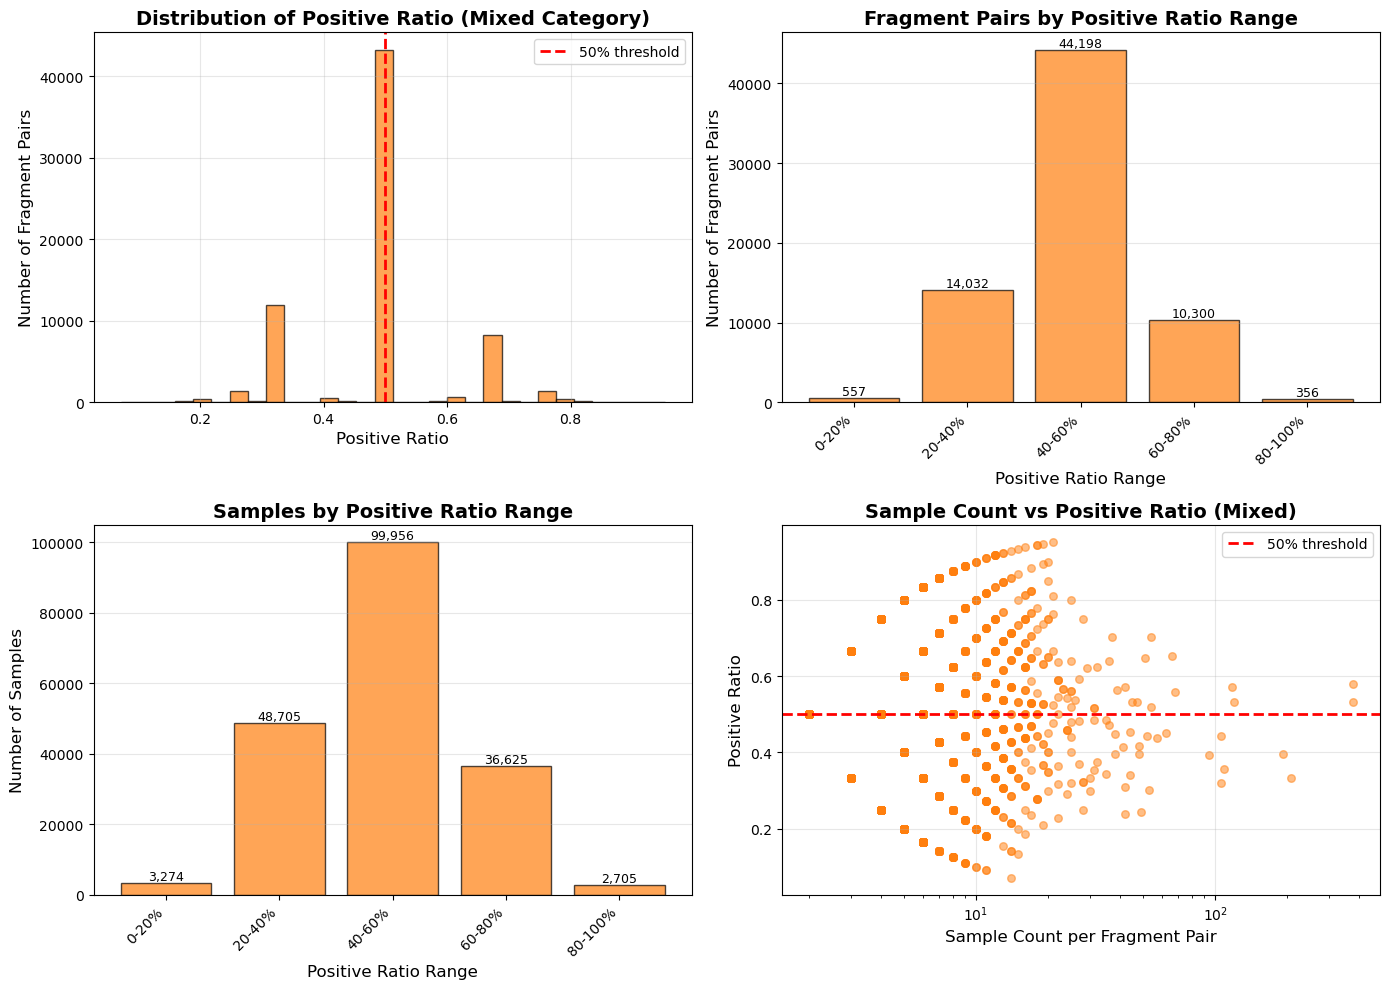


■ Figure: Detailed analysis of Mixed category


In [45]:
# Mixedカテゴリの詳細分析：positive/negativeの割合
mixed_pairs = frag_pair_label_stats[frag_pair_label_stats['consistency'] == 'Mixed']

if len(mixed_pairs) > 0:
    print("■ Detailed analysis of Mixed category:")
    print("="*80)
    
    # 基本統計
    print("\n【Basic statistics for Mixed pairs】")
    print(f"Total Mixed pairs: {len(mixed_pairs):,}")
    print(f"Total samples in Mixed pairs: {mixed_pairs['total_samples'].sum():,}")
    print(f"\nPositive ratio statistics:")
    print(mixed_pairs['positive_ratio'].describe())
    
    # positive_ratioで区分
    print("\n【Distribution by positive ratio range】")
    ratio_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ratio_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    
    mixed_pairs['ratio_category'] = pd.cut(mixed_pairs['positive_ratio'], 
                                            bins=ratio_bins, 
                                            labels=ratio_labels, 
                                            include_lowest=True)
    
    ratio_dist = mixed_pairs['ratio_category'].value_counts().sort_index()
    print("\nBy fragment pair count:")
    for category, count in ratio_dist.items():
        pct = count / len(mixed_pairs) * 100
        print(f"  Positive {category:10s}: {count:6,} pairs ({pct:5.1f}%)")
    
    # サンプル数でも集計
    print("\nBy sample count:")
    for category in ratio_labels:
        subset = mixed_pairs[mixed_pairs['ratio_category'] == category]
        sample_count = subset['total_samples'].sum()
        pct = sample_count / mixed_pairs['total_samples'].sum() * 100
        print(f"  Positive {category:10s}: {sample_count:7,} samples ({pct:5.1f}%)")
    
    # 可視化
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. positive_ratioのヒストグラム（詳細）
    axes[0, 0].hist(mixed_pairs['positive_ratio'], bins=30, 
                    alpha=0.7, color='#ff7f0e', edgecolor='black')
    axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[0, 0].set_xlabel('Positive Ratio', fontsize=12)
    axes[0, 0].set_ylabel('Number of Fragment Pairs', fontsize=12)
    axes[0, 0].set_title('Distribution of Positive Ratio (Mixed Category)', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. positive_ratio区分別のペア数（棒グラフ）
    axes[0, 1].bar(range(len(ratio_dist)), ratio_dist.values, 
                   color='#ff7f0e', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[0, 1].set_ylabel('Number of Fragment Pairs', fontsize=12)
    axes[0, 1].set_title('Fragment Pairs by Positive Ratio Range', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(len(ratio_dist)))
    axes[0, 1].set_xticklabels(ratio_dist.index, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for i, count in enumerate(ratio_dist.values):
        axes[0, 1].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # 3. サンプル数別の分布（棒グラフ）
    sample_counts_by_ratio = []
    for category in ratio_labels:
        subset = mixed_pairs[mixed_pairs['ratio_category'] == category]
        sample_counts_by_ratio.append(subset['total_samples'].sum())
    
    axes[1, 0].bar(range(len(ratio_labels)), sample_counts_by_ratio, 
                   color='#ff7f0e', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[1, 0].set_ylabel('Number of Samples', fontsize=12)
    axes[1, 0].set_title('Samples by Positive Ratio Range', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(range(len(ratio_labels)))
    axes[1, 0].set_xticklabels(ratio_labels, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    for i, count in enumerate(sample_counts_by_ratio):
        axes[1, 0].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # 4. サンプル数 vs positive_ratio の散布図
    axes[1, 1].scatter(mixed_pairs['total_samples'], mixed_pairs['positive_ratio'], 
                       alpha=0.5, s=30, color='#ff7f0e')
    axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[1, 1].set_xlabel('Sample Count per Fragment Pair', fontsize=12)
    axes[1, 1].set_ylabel('Positive Ratio', fontsize=12)
    axes[1, 1].set_title('Sample Count vs Positive Ratio (Mixed)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n■ Figure: Detailed analysis of Mixed category")
    print("="*80)
    
else:
    print("■ No Mixed pairs found in the dataset")
    print("="*80)


■ Label distribution (0 vs 1) within Mixed category by positive ratio range:

Positive ratio 0-20%     :
  Label 1 (Positive):     586 samples ( 17.9%)
  Label 0 (Negative):   2,688 samples ( 82.1%)
  Total:                3,274 samples

Positive ratio 20-40%    :
  Label 1 (Positive):  15,908 samples ( 32.7%)
  Label 0 (Negative):  32,797 samples ( 67.3%)
  Total:               48,705 samples

Positive ratio 40-60%    :
  Label 1 (Positive):  50,315 samples ( 50.3%)
  Label 0 (Negative):  49,641 samples ( 49.7%)
  Total:               99,956 samples

Positive ratio 60-80%    :
  Label 1 (Positive):  25,215 samples ( 68.8%)
  Label 0 (Negative):  11,410 samples ( 31.2%)
  Total:               36,625 samples

Positive ratio 80-100%   :
  Label 1 (Positive):   2,314 samples ( 85.5%)
  Label 0 (Negative):     391 samples ( 14.5%)
  Total:                2,705 samples


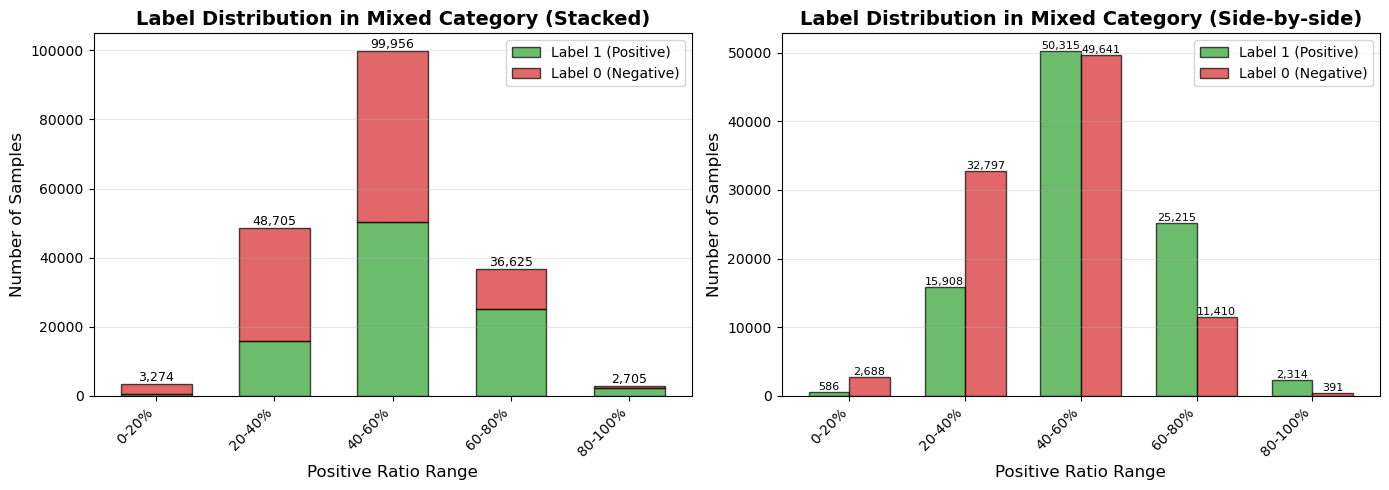


■ Figure: Label 0 vs Label 1 distribution within Mixed category

【Overall summary for Mixed category】
Total samples in Mixed pairs: 191,265
  Label 1 (Positive): 94,338 samples (49.3%)
  Label 0 (Negative): 96,927 samples (50.7%)


In [46]:
# Mixedカテゴリ：positive_ratio区分ごとのLabel 0/1の実際のサンプル数を可視化
if len(mixed_pairs) > 0:
    print("\n■ Label distribution (0 vs 1) within Mixed category by positive ratio range:")
    print("="*80)
    
    # 各positive_ratio区分内でのpositive(label=1)とnegative(label=0)のサンプル数を集計
    positive_samples_by_ratio = []
    negative_samples_by_ratio = []
    
    for category in ratio_labels:
        subset = mixed_pairs[mixed_pairs['ratio_category'] == category]
        pos_samples = subset['positive_count'].sum()
        neg_samples = subset['negative_count'].sum()
        positive_samples_by_ratio.append(pos_samples)
        negative_samples_by_ratio.append(neg_samples)
        
        total = pos_samples + neg_samples
        pos_pct = pos_samples / total * 100 if total > 0 else 0
        neg_pct = neg_samples / total * 100 if total > 0 else 0
        print(f"\nPositive ratio {category:10s}:")
        print(f"  Label 1 (Positive): {pos_samples:7,} samples ({pos_pct:5.1f}%)")
        print(f"  Label 0 (Negative): {neg_samples:7,} samples ({neg_pct:5.1f}%)")
        print(f"  Total:              {total:7,} samples")
    
    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. 積み上げ棒グラフ（Label 0とLabel 1）
    x = np.arange(len(ratio_labels))
    width = 0.6
    
    p1 = axes[0].bar(x, positive_samples_by_ratio, width, 
                     label='Label 1 (Positive)', color='#2ca02c', alpha=0.7, edgecolor='black')
    p2 = axes[0].bar(x, negative_samples_by_ratio, width, bottom=positive_samples_by_ratio,
                     label='Label 0 (Negative)', color='#d62728', alpha=0.7, edgecolor='black')
    
    axes[0].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[0].set_ylabel('Number of Samples', fontsize=12)
    axes[0].set_title('Label Distribution in Mixed Category (Stacked)', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(ratio_labels, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 総数を表示
    for i, (pos, neg) in enumerate(zip(positive_samples_by_ratio, negative_samples_by_ratio)):
        total = pos + neg
        axes[0].text(i, total, f'{total:,}', ha='center', va='bottom', fontsize=9)
    
    # 2. 並列棒グラフ（Label 0とLabel 1）
    width = 0.35
    x = np.arange(len(ratio_labels))
    
    axes[1].bar(x - width/2, positive_samples_by_ratio, width, 
                label='Label 1 (Positive)', color='#2ca02c', alpha=0.7, edgecolor='black')
    axes[1].bar(x + width/2, negative_samples_by_ratio, width, 
                label='Label 0 (Negative)', color='#d62728', alpha=0.7, edgecolor='black')
    
    axes[1].set_xlabel('Positive Ratio Range', fontsize=12)
    axes[1].set_ylabel('Number of Samples', fontsize=12)
    axes[1].set_title('Label Distribution in Mixed Category (Side-by-side)', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(ratio_labels, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 各バーの上に数値を表示
    for i, (pos, neg) in enumerate(zip(positive_samples_by_ratio, negative_samples_by_ratio)):
        axes[1].text(i - width/2, pos, f'{pos:,}', ha='center', va='bottom', fontsize=8)
        axes[1].text(i + width/2, neg, f'{neg:,}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\n■ Figure: Label 0 vs Label 1 distribution within Mixed category")
    print("="*80)
    
    # サマリー統計
    total_positive = sum(positive_samples_by_ratio)
    total_negative = sum(negative_samples_by_ratio)
    total_mixed = total_positive + total_negative
    
    print(f"\n【Overall summary for Mixed category】")
    print(f"Total samples in Mixed pairs: {total_mixed:,}")
    print(f"  Label 1 (Positive): {total_positive:,} samples ({total_positive/total_mixed*100:.1f}%)")
    print(f"  Label 0 (Negative): {total_negative:,} samples ({total_negative/total_mixed*100:.1f}%)")
    print("="*80)

## 6. フラグメントサイズの妥当性検証

### 6.1 REF-FRAG_heavy と PRB-FRAG_heavy の分布

■ Statistics of fragment sizes (REF-FRAG_heavy and PRB-FRAG_heavy):

REF-FRAG_heavy:
count    779081.000000
mean          9.006934
std           3.191902
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max          15.000000
Name: REF-FRAG_heavy, dtype: float64

PRB-FRAG_heavy:
count    779081.000000
mean          9.006934
std           3.191902
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max          15.000000
Name: REF-FRAG_heavy, dtype: float64

PRB-FRAG_heavy:
count    779081.000000
mean          9.009937
std           3.201411
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max          15.000000
Name: PRB-FRAG_heavy, dtype: float64

Max REF-FRAG_heavy: 15
Max PRB-FRAG_heavy: 15

■ Sample counts when BOTH fragments are below threshold:
REF ≤ 10 AND PRB ≤ 10: 410,843 samples (52.73%)
REF ≤ 12 AND PRB ≤ 12: 601,512 samples (77.21%)
REF ≤ 15 AND PRB 

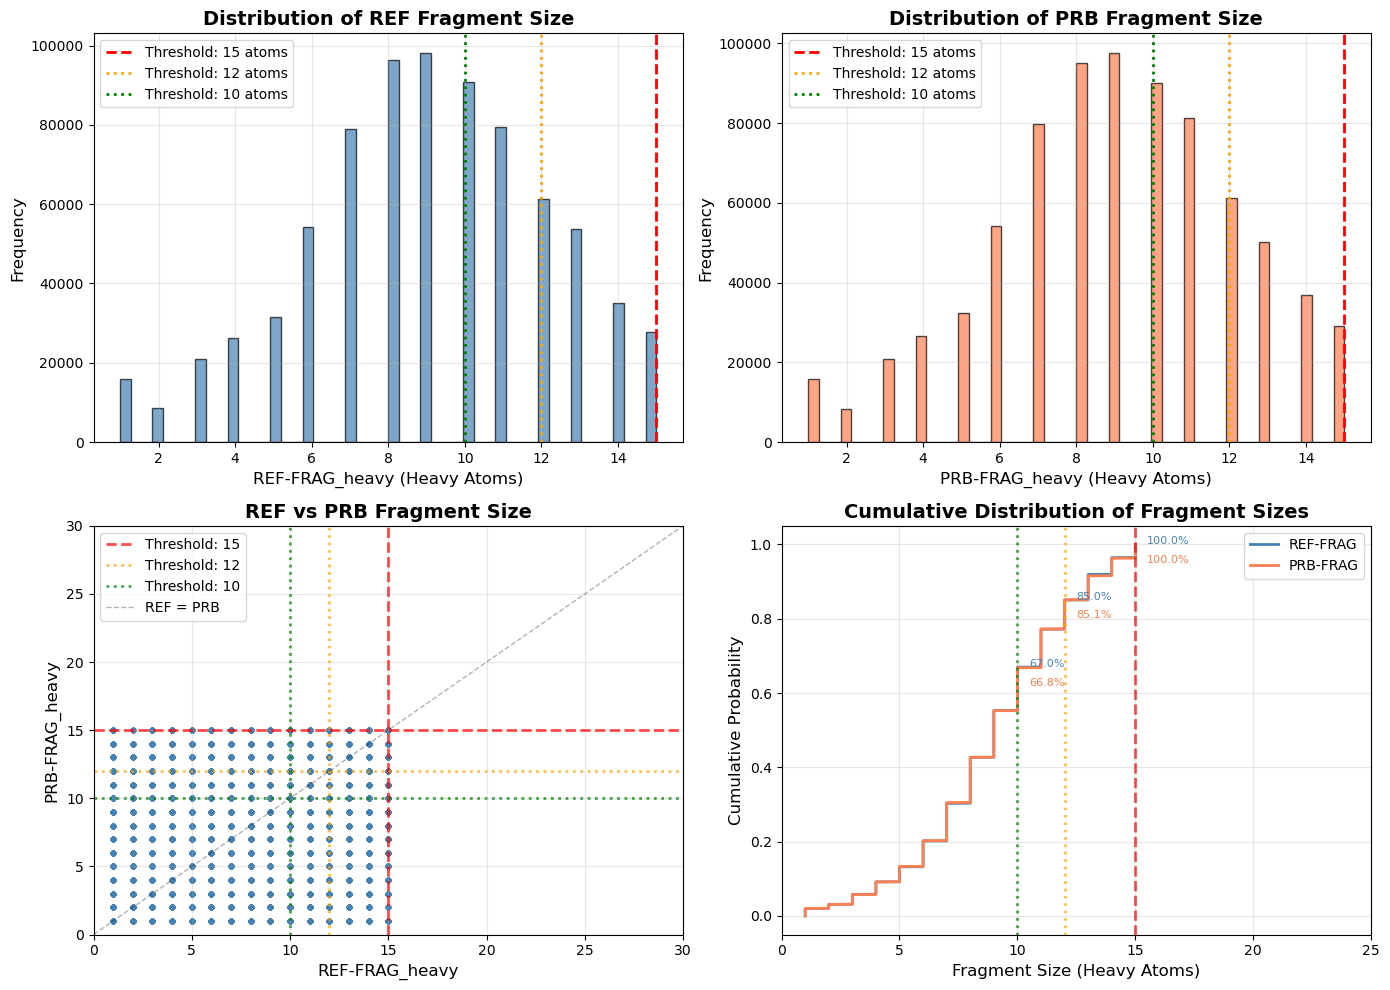

■ Figure 4: Distribution of REF and PRB fragment sizes


In [47]:
# REF-FRAG_heavy と PRB-FRAG_heavy の分布を確認
print("■ Statistics of fragment sizes (REF-FRAG_heavy and PRB-FRAG_heavy):")
print("\nREF-FRAG_heavy:")
print(df['REF-FRAG_heavy'].describe())
print("\nPRB-FRAG_heavy:")
print(df['PRB-FRAG_heavy'].describe())

# 各フラグメントの最大値を確認
print(f"\nMax REF-FRAG_heavy: {df['REF-FRAG_heavy'].max()}")
print(f"Max PRB-FRAG_heavy: {df['PRB-FRAG_heavy'].max()}")

# 閾値別のデータ件数（両方のフラグメントが閾値以下の場合）
print("\n■ Sample counts when BOTH fragments are below threshold:")
thresholds = [10, 12, 15, 20]
for threshold in thresholds:
    count = ((df['REF-FRAG_heavy'] <= threshold) & (df['PRB-FRAG_heavy'] <= threshold)).sum()
    print(f"REF ≤ {threshold} AND PRB ≤ {threshold}: {count:7,} samples ({count/len(df)*100:5.2f}%)")

# 閾値別のデータ件数（少なくとも一方が閾値以下の場合）
print("\n■ Sample counts when AT LEAST ONE fragment is below threshold:")
for threshold in thresholds:
    count = ((df['REF-FRAG_heavy'] <= threshold) | (df['PRB-FRAG_heavy'] <= threshold)).sum()
    print(f"REF ≤ {threshold} OR PRB ≤ {threshold}:  {count:7,} samples ({count/len(df)*100:5.2f}%)")

# 分布の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. REF-FRAG_heavyのヒストグラム
axes[0, 0].hist(df['REF-FRAG_heavy'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(x=15, color='red', linestyle='--', linewidth=2, label='Threshold: 15 atoms')
axes[0, 0].axvline(x=12, color='orange', linestyle=':', linewidth=2, label='Threshold: 12 atoms')
axes[0, 0].axvline(x=10, color='green', linestyle=':', linewidth=2, label='Threshold: 10 atoms')
axes[0, 0].set_xlabel('REF-FRAG_heavy (Heavy Atoms)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of REF Fragment Size', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. PRB-FRAG_heavyのヒストグラム
axes[0, 1].hist(df['PRB-FRAG_heavy'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].axvline(x=15, color='red', linestyle='--', linewidth=2, label='Threshold: 15 atoms')
axes[0, 1].axvline(x=12, color='orange', linestyle=':', linewidth=2, label='Threshold: 12 atoms')
axes[0, 1].axvline(x=10, color='green', linestyle=':', linewidth=2, label='Threshold: 10 atoms')
axes[0, 1].set_xlabel('PRB-FRAG_heavy (Heavy Atoms)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of PRB Fragment Size', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 散布図（REF vs PRB）
axes[1, 0].scatter(df['REF-FRAG_heavy'], df['PRB-FRAG_heavy'], 
                   alpha=0.3, s=10, color='steelblue')
axes[1, 0].axvline(x=15, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 0].axhline(y=15, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold: 15')
axes[1, 0].axvline(x=12, color='orange', linestyle=':', linewidth=2, alpha=0.7)
axes[1, 0].axhline(y=12, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Threshold: 12')
axes[1, 0].axvline(x=10, color='green', linestyle=':', linewidth=2, alpha=0.7)
axes[1, 0].axhline(y=10, color='green', linestyle=':', linewidth=2, alpha=0.7, label='Threshold: 10')
axes[1, 0].plot([0, 30], [0, 30], 'k--', alpha=0.3, linewidth=1, label='REF = PRB')
axes[1, 0].set_xlabel('REF-FRAG_heavy', fontsize=12)
axes[1, 0].set_ylabel('PRB-FRAG_heavy', fontsize=12)
axes[1, 0].set_title('REF vs PRB Fragment Size', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 30)
axes[1, 0].set_ylim(0, 30)

# 4. 累積分布（両方）
sorted_ref = np.sort(df['REF-FRAG_heavy'])
sorted_prb = np.sort(df['PRB-FRAG_heavy'])
cdf_ref = np.arange(1, len(sorted_ref) + 1) / len(sorted_ref)
cdf_prb = np.arange(1, len(sorted_prb) + 1) / len(sorted_prb)

axes[1, 1].plot(sorted_ref, cdf_ref, linewidth=2, color='steelblue', label='REF-FRAG')
axes[1, 1].plot(sorted_prb, cdf_prb, linewidth=2, color='coral', label='PRB-FRAG')
axes[1, 1].axvline(x=15, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 1].axvline(x=12, color='orange', linestyle=':', linewidth=2, alpha=0.7)
axes[1, 1].axvline(x=10, color='green', linestyle=':', linewidth=2, alpha=0.7)

for threshold in [10, 12, 15]:
    cdf_val_ref = (df['REF-FRAG_heavy'] <= threshold).sum() / len(df)
    cdf_val_prb = (df['PRB-FRAG_heavy'] <= threshold).sum() / len(df)
    axes[1, 1].text(threshold + 0.5, cdf_val_ref, f'{cdf_val_ref:.1%}', fontsize=8, color='steelblue')
    axes[1, 1].text(threshold + 0.5, cdf_val_prb - 0.05, f'{cdf_val_prb:.1%}', fontsize=8, color='coral')

axes[1, 1].set_xlabel('Fragment Size (Heavy Atoms)', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution of Fragment Sizes', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 25)

plt.tight_layout()
plt.show()

print("■ Figure 4: Distribution of REF and PRB fragment sizes")

### 6.2 閾値の感度分析 (10 / 12 / 15 原子)

■ Threshold sensitivity analysis (10 / 12 / 15 atoms):
  Condition: BOTH REF-FRAG_heavy ≤ threshold AND PRB-FRAG_heavy ≤ threshold
 Threshold  N_Samples  N_FragPairs  N_SMILESPairs  N_Positive  N_Negative  Positive_Ratio  Mean_REF_heavy  Mean_PRB_heavy  Mean_|Delta|  Std_Delta
        10     410843       284983         272888      184139      226704        0.448198        7.043705        7.035403      0.527026   0.771172
        12     601512       426995         395863      261375      340137        0.434530        8.024876        8.025158      0.553042   0.805842
        15     779081       567744         521222      330940      448141        0.424783        9.006934        9.009937      0.572101   0.831911


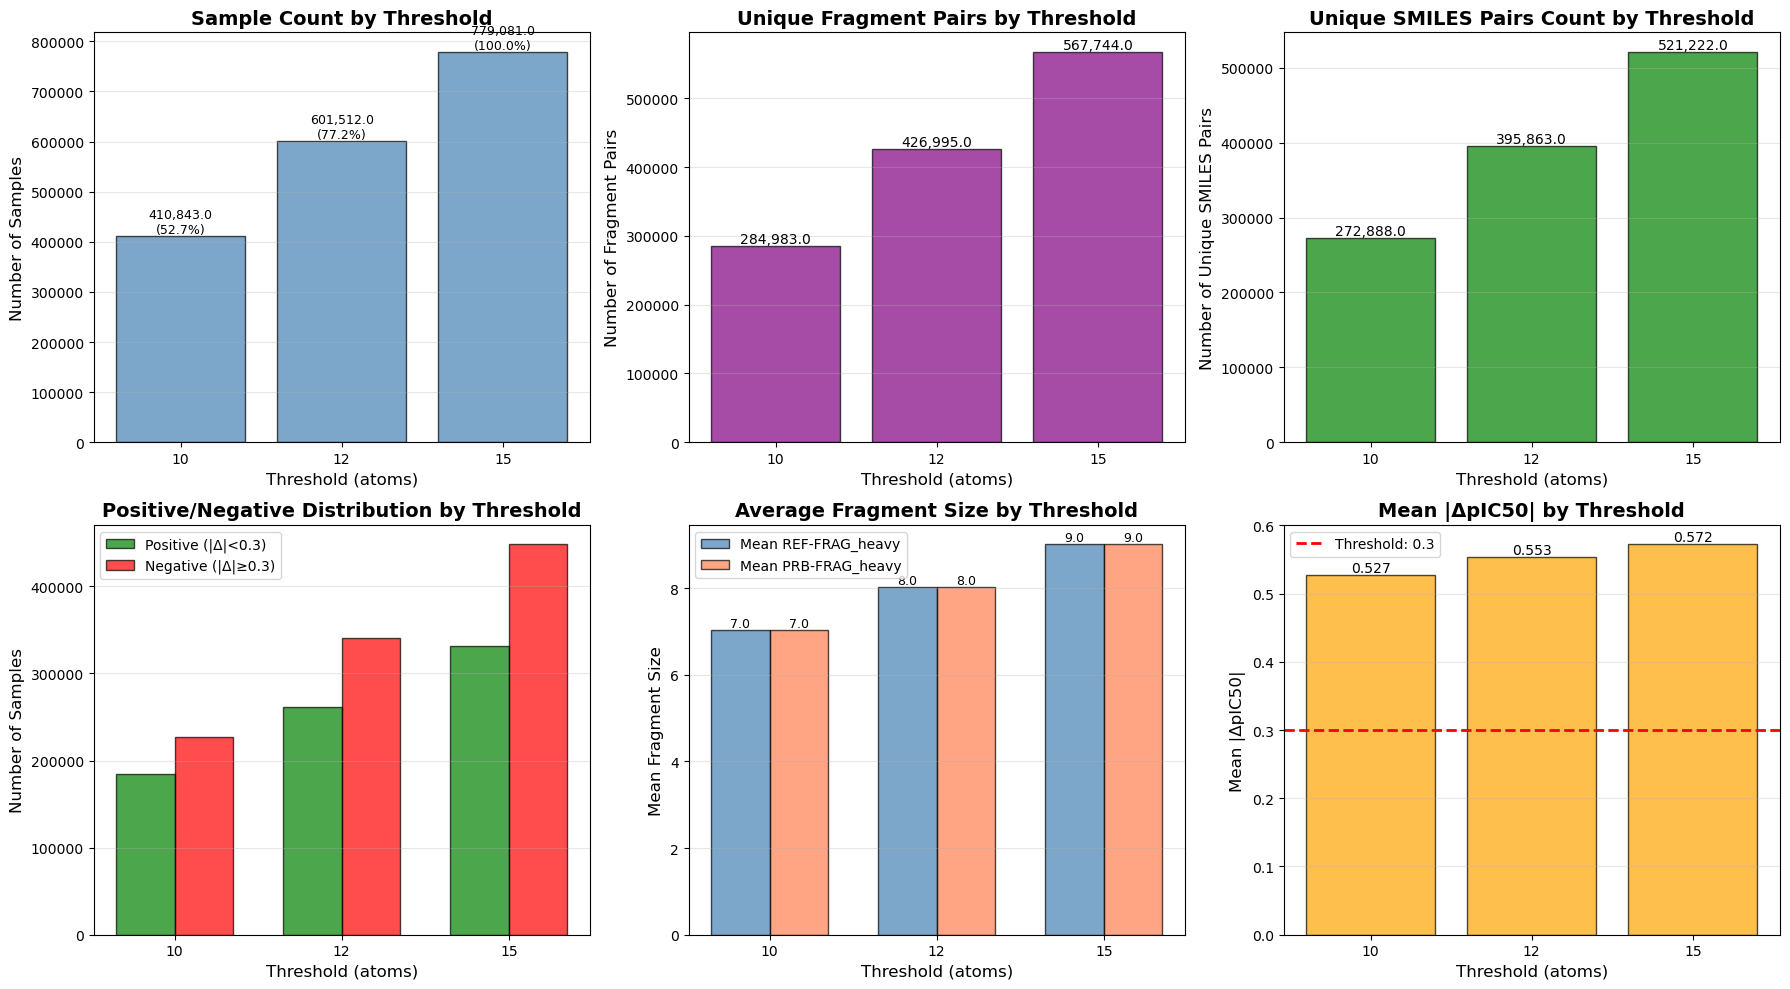


■ Figure 5: Threshold sensitivity analysis for fragment sizes


In [48]:
# 閾値ごとにデータセットを作成し、統計を比較（両方のフラグメントが閾値以下の場合）
thresholds = [10, 12, 15]
sensitivity_results = []

for threshold in thresholds:
    # 両方のフラグメントが閾値以下のデータに絞る
    df_filtered = df[(df['REF-FRAG_heavy'] <= threshold) & (df['PRB-FRAG_heavy'] <= threshold)]
    
    # 基本統計
    n_samples = len(df_filtered)
    n_frag_pairs = df_filtered['FRAG_PAIR'].nunique() if 'FRAG_PAIR' in df_filtered.columns else 0
    
    # SMILESペア(順不同)の数を計算
    df_filtered_copy = df_filtered.copy()
    df_filtered_copy['SMILES_PAIR'] = df_filtered_copy.apply(
        lambda row: tuple(sorted([row['REF-SMILES'], row['PRB-SMILES']])), 
        axis=1
    )
    n_smiles_pairs = df_filtered_copy['SMILES_PAIR'].nunique()
    
    n_positive = (df_filtered['delta_value'].abs() < 0.3).sum()
    n_negative = (df_filtered['delta_value'].abs() >= 0.3).sum()
    
    # ΔpIC50の統計
    mean_delta = df_filtered['delta_value'].abs().mean() if n_samples > 0 else 0
    std_delta = df_filtered['delta_value'].std() if n_samples > 0 else 0
    
    # フラグメントサイズの統計
    mean_ref = df_filtered['REF-FRAG_heavy'].mean() if n_samples > 0 else 0
    mean_prb = df_filtered['PRB-FRAG_heavy'].mean() if n_samples > 0 else 0
    
    sensitivity_results.append({
        'Threshold': threshold,
        'N_Samples': n_samples,
        'N_FragPairs': n_frag_pairs,
        'N_SMILESPairs': n_smiles_pairs,
        'N_Positive': n_positive,
        'N_Negative': n_negative,
        'Positive_Ratio': n_positive / n_samples if n_samples > 0 else 0,
        'Mean_REF_heavy': mean_ref,
        'Mean_PRB_heavy': mean_prb,
        'Mean_|Delta|': mean_delta,
        'Std_Delta': std_delta
    })

# 結果を表示
sensitivity_df = pd.DataFrame(sensitivity_results)
print("■ Threshold sensitivity analysis (10 / 12 / 15 atoms):")
print("  Condition: BOTH REF-FRAG_heavy ≤ threshold AND PRB-FRAG_heavy ≤ threshold")
print("="*120)
print(sensitivity_df.to_string(index=False))
print("="*120)

# 可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. サンプル数の比較
axes[0, 0].bar(sensitivity_df['Threshold'].astype(str), sensitivity_df['N_Samples'], 
               alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Threshold (atoms)', fontsize=12)
axes[0, 0].set_ylabel('Number of Samples', fontsize=12)
axes[0, 0].set_title('Sample Count by Threshold', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, row in sensitivity_df.iterrows():
    axes[0, 0].text(i, row['N_Samples'], f"{row['N_Samples']:,}\n({row['N_Samples']/len(df)*100:.1f}%)", 
                     ha='center', va='bottom', fontsize=9)

# 2. フラグメントペア数の比較
axes[0, 1].bar(sensitivity_df['Threshold'].astype(str), sensitivity_df['N_FragPairs'], 
               alpha=0.7, color='purple', edgecolor='black')
axes[0, 1].set_xlabel('Threshold (atoms)', fontsize=12)
axes[0, 1].set_ylabel('Number of Fragment Pairs', fontsize=12)
axes[0, 1].set_title('Unique Fragment Pairs by Threshold', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, row in sensitivity_df.iterrows():
    axes[0, 1].text(i, row['N_FragPairs'], f"{row['N_FragPairs']:,}", 
                     ha='center', va='bottom', fontsize=10)

# 3. SMILESペア数の比較
axes[0, 2].bar(sensitivity_df['Threshold'].astype(str), sensitivity_df['N_SMILESPairs'], 
               alpha=0.7, color='green', edgecolor='black')
axes[0, 2].set_xlabel('Threshold (atoms)', fontsize=12)
axes[0, 2].set_ylabel('Number of Unique SMILES Pairs', fontsize=12)
axes[0, 2].set_title('Unique SMILES Pairs Count by Threshold', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')
for i, row in sensitivity_df.iterrows():
    axes[0, 2].text(i, row['N_SMILESPairs'], f"{row['N_SMILESPairs']:,}", 
                     ha='center', va='bottom', fontsize=10)

# 4. Positive/Negative比率の比較
x = np.arange(len(sensitivity_df))
width = 0.35
axes[1, 0].bar(x - width/2, sensitivity_df['N_Positive'], width, 
               label='Positive (|Δ|<0.3)', alpha=0.7, color='green', edgecolor='black')
axes[1, 0].bar(x + width/2, sensitivity_df['N_Negative'], width, 
               label='Negative (|Δ|≥0.3)', alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_xlabel('Threshold (atoms)', fontsize=12)
axes[1, 0].set_ylabel('Number of Samples', fontsize=12)
axes[1, 0].set_title('Positive/Negative Distribution by Threshold', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(sensitivity_df['Threshold'].astype(str))
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. 平均フラグメントサイズの比較
x = np.arange(len(sensitivity_df))
width = 0.35
axes[1, 1].bar(x - width/2, sensitivity_df['Mean_REF_heavy'], width, 
               label='Mean REF-FRAG_heavy', alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 1].bar(x + width/2, sensitivity_df['Mean_PRB_heavy'], width, 
               label='Mean PRB-FRAG_heavy', alpha=0.7, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Threshold (atoms)', fontsize=12)
axes[1, 1].set_ylabel('Mean Fragment Size', fontsize=12)
axes[1, 1].set_title('Average Fragment Size by Threshold', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(sensitivity_df['Threshold'].astype(str))
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, row in sensitivity_df.iterrows():
    axes[1, 1].text(i - width/2, row['Mean_REF_heavy'], f"{row['Mean_REF_heavy']:.1f}", 
                     ha='center', va='bottom', fontsize=9)
    axes[1, 1].text(i + width/2, row['Mean_PRB_heavy'], f"{row['Mean_PRB_heavy']:.1f}", 
                     ha='center', va='bottom', fontsize=9)

# 6. 平均|ΔpIC50|の比較
axes[1, 2].bar(sensitivity_df['Threshold'].astype(str), sensitivity_df['Mean_|Delta|'], 
               alpha=0.7, color='orange', edgecolor='black')
axes[1, 2].axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Threshold: 0.3')
axes[1, 2].set_xlabel('Threshold (atoms)', fontsize=12)
axes[1, 2].set_ylabel('Mean |ΔpIC50|', fontsize=12)
axes[1, 2].set_title('Mean |ΔpIC50| by Threshold', fontsize=14, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')
for i, row in sensitivity_df.iterrows():
    axes[1, 2].text(i, row['Mean_|Delta|'], f"{row['Mean_|Delta|']:.3f}", 
                     ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n■ Figure 5: Threshold sensitivity analysis for fragment sizes")

## 7. まとめと結論

### 7.1 主要な発見

In [49]:
# サマリーレポートの作成
print("="*80)
print("Dataset Definition, Statistics, and Validity Analysis Summary Report")
print("="*80)

print("\n【1. Basic Dataset Information】")
print(f"  - Total samples: {len(df):,}")
print(f"  - Unique fragment pairs (unordered): {len(grouped_counts_unordered):,} types")
print(f"  - Unique SMIRKS: {df['SMIRKS'].nunique():,} types")
print(f"  - Unique targets (TID): {df['TID'].nunique():,} types")
print(f"  - Unique assays (AID): {df['AID'].nunique():,} types")

print("\n【2. Distribution of ΔpIC50】")
print(f"  - Mean: {df['delta_value'].mean():.3f}")
print(f"  - Median: {df['delta_value'].median():.3f}")
print(f"  - Standard deviation: {df['delta_value'].std():.3f}")
print(f"  - Range: [{df['delta_value'].min():.3f}, {df['delta_value'].max():.3f}]")

print("\n【3. Relationship with Threshold 0.3】")
positive_count = (df['delta_value'].abs() < 0.3).sum()
negative_count = (df['delta_value'].abs() >= 0.3).sum()
print(f"  - |ΔpIC50| < 0.3 (Bioisostere): {positive_count:,} samples ({positive_count/len(df)*100:.2f}%)")
print(f"  - |ΔpIC50| ≥ 0.3 (Non-bioisostere): {negative_count:,} samples ({negative_count/len(df)*100:.2f}%)")
print(f"  - Threshold 0.3 is {0.3 / df['delta_value'].std():.2f}× the overall std")

print("\n【4. Sample Counts per Fragment Pair (unordered)】")
frag_pair_counts = grouped_counts_unordered['count']
print(f"  - n ≥ 1: {(frag_pair_counts >= 1).sum():,} types")
print(f"  - n ≥ 3: {(frag_pair_counts >= 3).sum():,} types ({(frag_pair_counts >= 3).sum()/len(frag_pair_counts)*100:.1f}%)")
print(f"  - n ≥ 5: {(frag_pair_counts >= 5).sum():,} types ({(frag_pair_counts >= 5).sum()/len(frag_pair_counts)*100:.1f}%)")
print(f"  - n ≥ 10: {(frag_pair_counts >= 10).sum():,} types ({(frag_pair_counts >= 10).sum()/len(frag_pair_counts)*100:.1f}%)")

print("\n【5. Fragment Size (VAR_heavy_sum)】")
print(f"  - Mean: {df['VAR_heavy_sum'].mean():.1f} atoms")
print(f"  - Median: {df['VAR_heavy_sum'].median():.1f} atoms")
print(f"  - ≤ 15 atoms: {(df['VAR_heavy_sum'] <= 15).sum():,} samples ({(df['VAR_heavy_sum'] <= 15).sum()/len(df)*100:.2f}%)")

print("\n【6. Sensitivity Analysis (Sample Count)】")
for threshold in [10, 15, 20]:
    count = (df['VAR_heavy_sum'] <= threshold).sum()
    print(f"  - VAR_heavy_sum ≤ {threshold}: {count:,} samples ({count/len(df)*100:.1f}%)")

print("\n【7. ΔpIC50 = 0.0 Analysis】")
zero_count = (df['delta_value'] == 0.0).sum()
print(f"  - Exact 0.0: {zero_count:,} samples ({zero_count/len(df)*100:.2f}%)")
if zero_count > 0:
    df_zero_temp = df[df['delta_value'] == 0.0]
    identical_smiles_temp = (df_zero_temp['REF-SMILES'] == df_zero_temp['PRB-SMILES']).sum()
    print(f"  - Identical SMILES: {identical_smiles_temp:,} samples ({identical_smiles_temp/zero_count*100:.1f}%)")

print("\n【8. Recommendations】")
print("  ✓ Bioisostere definition: |ΔpIC50| < 0.3")
print("  ✓ Minimum samples per transformation: n ≥ 3 recommended")
print("  ✓ Fragment size: ≤15 atoms as standard, with sensitivity analysis at 10/20 atoms")
print("  ✓ Explicitly state positive/negative ratio in the paper")
print("  ✓ Add discussion on experimental noise scale and threshold relationship")
print("  ✓ Investigate and explain the high frequency of ΔpIC50 = 0.0 samples")

print("="*80)

Dataset Definition, Statistics, and Validity Analysis Summary Report

【1. Basic Dataset Information】
  - Total samples: 779,081
  - Unique fragment pairs (unordered): 380,847 types
  - Unique SMIRKS: 621,522 types
  - Unique targets (TID): 1,897 types
  - Unique assays (AID): 12,585 types

【2. Distribution of ΔpIC50】
  - Mean: -0.008
  - Median: 0.000
  - Standard deviation: 0.832
  - Range: [-6.699, 4.989]

【3. Relationship with Threshold 0.3】
  - |ΔpIC50| < 0.3 (Bioisostere): 330,940 samples (42.48%)
  - |ΔpIC50| ≥ 0.3 (Non-bioisostere): 448,141 samples (57.52%)
  - Threshold 0.3 is 0.36× the overall std

【4. Sample Counts per Fragment Pair (unordered)】
  - n ≥ 1: 380,847 types
  - n ≥ 3: 89,893 types (23.6%)
  - n ≥ 5: 16,029 types (4.2%)
  - n ≥ 10: 4,296 types (1.1%)

【5. Fragment Size (VAR_heavy_sum)】
  - Mean: 18.0 atoms
  - Median: 18.0 atoms
  - ≤ 15 atoms: 233,816 samples (30.01%)

【6. Sensitivity Analysis (Sample Count)】
  - VAR_heavy_sum ≤ 10: 75,402 samples (9.7%)
  - VAR_